# <h1><center>OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction</center></h1>

## <span style='color:Blue'> Problèmatique  </span>

L'un des plus grands défis à l'heure actuelle est de savoir comment concevoir des molécules d'ARN messager (ARNm) super stables.Les chercheurs ont observé que les molécules d'ARN ont tendance à se dégrader spontanément. C'est une limitation sérieuse - une seule coupure peut rendre le vaccin à ARNm inutile.

## <span style='color:Blue'> But  </span>

Le present notebook a pour but de chercher à tirer parti de lexpertise en science des données de la communauté Kaggle pour faire une étude sur des modèles et des règles de conception pour la dégradation de lARN.
Nous devons impliquer une étude sur un modèle qui prédira les taux de dégradation probables à chaque base d une molécule dARN, 
formé sur un sous-ensemble d un ensemble de données Eterna comprenant plus de 3000 molécules d'ARN (qui couvrent une panoplie de séquences et de structures) et leurs taux de dégradation à chaque position.

## <span style='color:Blue'> Sommaire  </span>

    1.EDA (Exploratory Data Analysis)
    2.Features engineering & Pre-processing
    3.Modeling

## <span style='color:Blue'> DATA DESCRIPTION  </span>

Dans cette compétition, nous prédisons les taux de dégradation à divers endroits le long de la séquence d'ARN.

Il existe plusieurs valeurs de vérité terrain fournies dans les données d'apprentissage. Bien que le format de soumission nécessite que les 5 soient prédits, seuls les éléments suivants sont notés: réactivité, deg_Mg_pH10 et deg_Mg_50C.

## <span style='color:Blue'> COLUMNS </span>

1. <span style='color:red'> id </span> - Un identifiant arbitraire pour chaque échantillon. <br>
2. <span style='color:red'> seqscored </span> - Valeur entière indiquant le nombre de positions utilisées dans la notation avec des valeurs prédites. <br>
3. <span style='color:red'> seq_length </span> - (Valeurs entières indique la longueur de la séquence.  <br>
4. <span style='color:red'> sequence </span> - Décrit la séquence d'ARN, une combinaison de A, G, U et C pour chaque échantillon.  <br>
5. <span style='color:red'> structure </span> - Un tableau de (,) et. Caractères qui décrivent si une base est estimée être appariée ou non appariée. Les bases appariées sont indiquées par des parenthèses ouvrantes et fermantes. <br>
6. <span style='color:red'> reactivity </span> - Un tableau de nombres à virgule flottante Date d’entrée Ces nombres sont utilisés pour déterminer la structure secondaire probable de l'échantillon d’ARN. <br>
7. <span style='color:red'> deg_pH10 </span> - Un tableau de nombres à virgule flottante. Ces nombres sont utilisés pour déterminer la probabilité de dégradation au niveau de la base / liaison après incubation sans magnésium à pH élevé (pH 10). <br>
8. <span style='color:red'> deg_Mg_pH10 </span> - Un tableau de nombres à virgule flottante. Ces nombres sont utilisés pour déterminer la probabilité de dégradation à la base / liaison après incubation avec du magnésium à pH élevé (pH 10). <br>
9. <span style='color:red'> deg_50C </span> - Un tableau de nombres à virgule flottante. Ces nombres sont utilisés pour déterminer la probabilité de dégradation au niveau de la base / liaison après incubation sans magnésium à haute température (50 degrés Celsius). <br>
10. <span style='color:red'> deg_Mg_50C </span> - Un tableau de nombres à virgule flottante. Ces nombres sont utilisés pour déterminer la probabilité de dégradation au niveau de la base / liaison après incubation avec du magnésium à haute température (50 degrés Celsius). <br>
11. <span style='color:red'> error </span> - Un tableau de nombres à virgule flottante, les erreurs calculées dans les valeurs expérimentales obtenues dans les colonnes de réactivité et deg_ *. <br>
12. <span style='color:red'> predicted_loop_type </span> - Types de boucles attribués par bpRNA de la structure Vienna RNAfold 2. <br>

## <span style='color:Blue'> Importation des données </span>

In [2]:
%%capture
import sys
!cp ../input/rapids/rapids.0.15.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from matplotlib.colors import ListedColormap
import warnings
import json
import collections
from functools import reduce
import seaborn as sns
import tensorflow.keras.layers as L
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import SelectKBest, f_classif
warnings.filterwarnings('ignore')

## <span style='color:Blue'> Lecture des fichiers JSON et CSV </span>

In [7]:
path = "C:/Users/ESSABRI hamza/Desktop/S5/pfa/stanford-covid-vaccine/"
path_npy = "C:/Users/ESSABRI hamza/Desktop/S5/pfa/stanford-covid-vaccine/bpps/"
train = pd.read_json(f"{path}train.json", lines=True)
test = pd.read_json(f"{path}test.json", lines=True)
submission = pd.read_csv(f"{path}sample_submission.csv")

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## <span style='color:Blue'> EDA (EXPLORATORY DATA ANALYSIS) </span>

In [16]:
train.head()

index            id                                           sequence  \
0      0  id_001f94081  GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...   
1      1  id_0049f53ba  GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...   
2      2  id_006f36f57  GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...   
3      3  id_0082d463b  GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...   
4      4  id_0087940f4  GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...   

                                           structure  \
0  .....((((((.......)))).)).((.....((..((((((......   
1  .....(((((((((((((((((((((((....)))))))))).)))...   
2  .....((((.((.....((((.(((.....)))..((((......)...   
3  ......((((((((((((((((......))))))))))))))))((...   
4  .....(((((((.((((((((((((.(((((((((....)))))))...   

                                 predicted_loop_type  signal_to_noise  \
0  EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...            6.894   
1  EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...            0.193   
2  EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...            8.800   
3  EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...            0.104   
4  EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...            0.423   

   SN_filter  seq_length  seq_scored  \
0          1         107          68   
1          0         107          68   
2          1         107          68   
3          0         107          68   
4          0         107          68   

                                    reactivity_error  \
0  [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...   
1  [2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...   
2  [0.0931, 0.13290000000000002, 0.11280000000000...   
3  [3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...   
4  [1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...   

                                   deg_error_Mg_pH10  \
0  [0.26130000000000003, 0.38420000000000004, 0.1...   
1  [73705.3985, 73705.3985, 73705.3985, 73705.398...   
2  [0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...   
3  [73705.3985, 73705.3985, 73705.3985, 73705.398...   
4  [4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...   

                                      deg_error_pH10  \
0  [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...   
1  [10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...   
2  [0.17020000000000002, 0.178, 0.111, 0.091, 0.0...   
3  [11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...   
4  [3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...   

                                    deg_error_Mg_50C  \
0  [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...   
1  [16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...   
2  [0.1033, 0.1464, 0.1126, 0.09620000000000001, ...   
3  [121286.7181, 121286.7182, 121286.7181, 121286...   
4  [2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...   

                                       deg_error_50C  \
0  [0.2167, 0.34750000000000003, 0.188, 0.2124, 0...   
1  [15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...   
2  [0.14980000000000002, 0.1761, 0.1517, 0.116700...   
3  [15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...   
4  [1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...   

                                          reactivity  \
0  [0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...   
1  [0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....   
2  [0.44820000000000004, 1.4822, 1.1819, 0.743400...   
3  [0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
4  [0.8267, 2.6577, 2.8481, 0.40090000000000003, ...   

                                         deg_Mg_pH10  \
0  [0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.2504, 1.4021, 0.9804, 0.49670000000000003, ...   
3  [0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
4  [2.1058, 3.138, 2.5437000000000003, 1.0932, 0....   

                                            deg_pH10  \
0  [2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...   
1  [4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [17]:
test.head()

index            id                                           sequence  \
0      0  id_00073f8be  GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...   
1      1  id_000ae4237  GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...   
2      2  id_00131c573  GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...   
3      3  id_00181fd34  GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...   
4      4  id_0020473f7  GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...   

                                           structure  \
0  ......((((((((((.(((((.....))))))))((((((((......   
1  .....((((..((((((...(((((.....((((....)))).......   
2  ...........((.(((.(.(..((..((..((((...))))..))...   
3  ......((((((((((....))))))))))((((((..((.(((.....   
4  .....(((((((((((((((((((((((((((((((((((((((((...   

                                 predicted_loop_type  seq_length  seq_scored  
0  EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...         107          68  
1  EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...         130          91  
2  EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...         107          68  
3  EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...         107          68  
4  EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...         130          91

In [18]:
submission.head()

id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C  deg_50C
0  id_00073f8be_0         0.0          0.0       0.0         0.0      0.0
1  id_00073f8be_1         0.0          0.0       0.0         0.0      0.0
2  id_00073f8be_2         0.0          0.0       0.0         0.0      0.0
3  id_00073f8be_3         0.0          0.0       0.0         0.0      0.0
4  id_00073f8be_4         0.0          0.0       0.0         0.0      0.0

In [19]:
train.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')

In [20]:
test.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'seq_length', 'seq_scored'],
      dtype='object')

In [21]:
submission.columns

Index(['id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C',
       'deg_50C'],
      dtype='object')

In [22]:
print("Train data shape: ",train.shape)
print("Test data shape: ",test.shape)
print("Sample submission shape: ",submission.shape)

Train data shape:  (2400, 19)
Test data shape:  (3634, 7)
Sample submission shape:  (457953, 6)


### <span style='color:Green'> Vérifications des données Manquantes </span>

In [23]:
train.isnull().any()

index                  False
id                     False
sequence               False
structure              False
predicted_loop_type    False
signal_to_noise        False
SN_filter              False
seq_length             False
seq_scored             False
reactivity_error       False
deg_error_Mg_pH10      False
deg_error_pH10         False
deg_error_Mg_50C       False
deg_error_50C          False
reactivity             False
deg_Mg_pH10            False
deg_pH10               False
deg_Mg_50C             False
deg_50C                False
dtype: bool

In [24]:
test.isnull().any()

index                  False
id                     False
sequence               False
structure              False
predicted_loop_type    False
seq_length             False
seq_scored             False
dtype: bool

In [25]:
submission.isnull().any()

id_seqpos      False
reactivity     False
deg_Mg_pH10    False
deg_pH10       False
deg_Mg_50C     False
deg_50C        False
dtype: bool

### <span style='color:Green'> Information sur les tables </span>

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-null   o

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3634 entries, 0 to 3633
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   index                3634 non-null   int64 
 1   id                   3634 non-null   object
 2   sequence             3634 non-null   object
 3   structure            3634 non-null   object
 4   predicted_loop_type  3634 non-null   object
 5   seq_length           3634 non-null   int64 
 6   seq_scored           3634 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 198.9+ KB


In [28]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457953 entries, 0 to 457952
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id_seqpos    457953 non-null  object 
 1   reactivity   457953 non-null  float64
 2   deg_Mg_pH10  457953 non-null  float64
 3   deg_pH10     457953 non-null  float64
 4   deg_Mg_50C   457953 non-null  float64
 5   deg_50C      457953 non-null  float64
dtypes: float64(5), object(1)
memory usage: 21.0+ MB


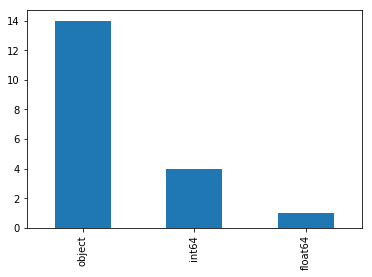

In [29]:
train.dtypes.value_counts().plot.bar()

Train dispose de 14 colonnes de type object, 4 colonnes de type int et 2 colonnes de type float

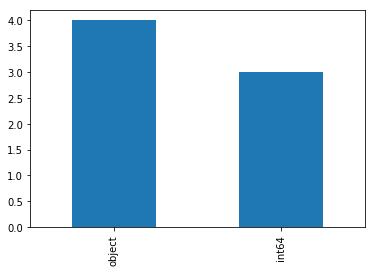

In [30]:
test.dtypes.value_counts().plot.bar()

Test dispose de 4 colonnes de type object et 3 colonnes de type int

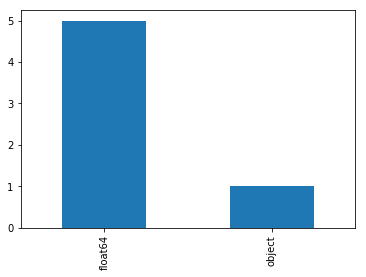

In [31]:
submission.dtypes.value_counts().plot.bar()

sample_submission dispose de 1 colonnes de type object et 5 colonnes de type int

Text(0.5,1,'submission')

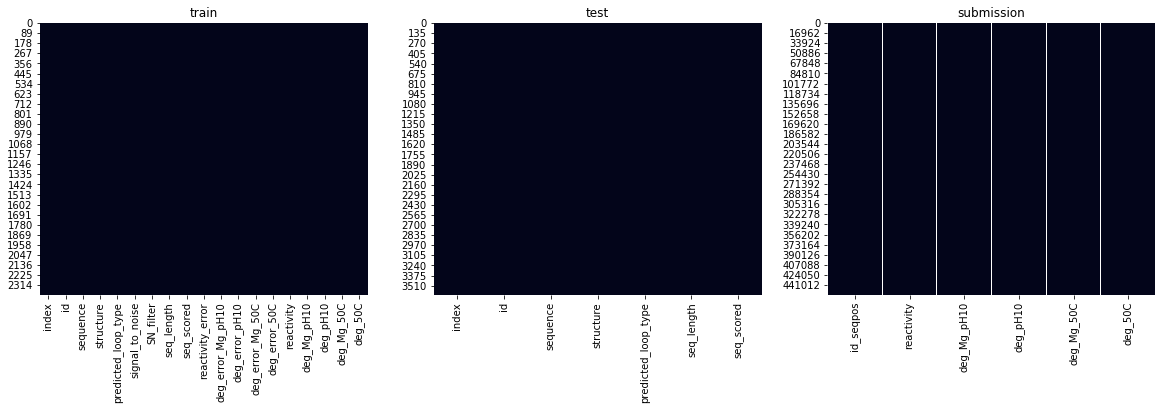

In [32]:
fig, axe = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(train.isna(), cbar=False, ax=axe[0])
sns.heatmap(test.isna(), cbar=False, ax=axe[1])
sns.heatmap(submission.isna(), cbar=False, ax=axe[2])

axe[0].set_title('train')
axe[1].set_title('test')
axe[2].set_title('submission')


On constate qu'on a aucune valeur manquante.

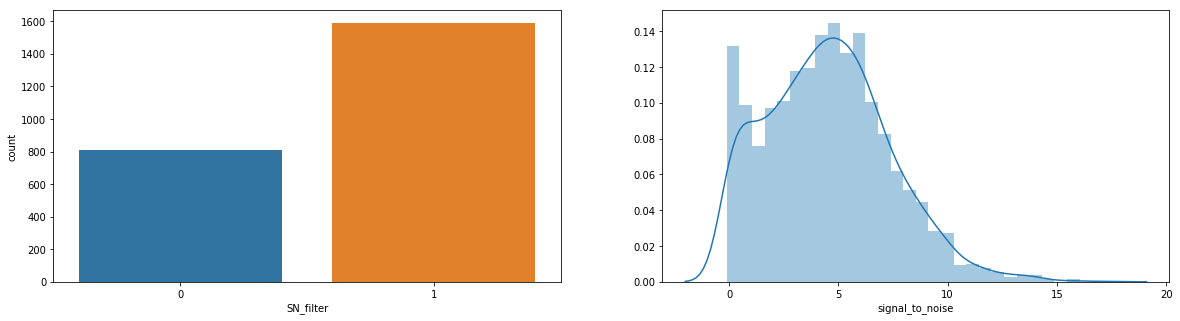

In [33]:
fig, axe = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(train['SN_filter'], ax=axe[0])
sns.distplot(train['signal_to_noise'], ax=axe[1])

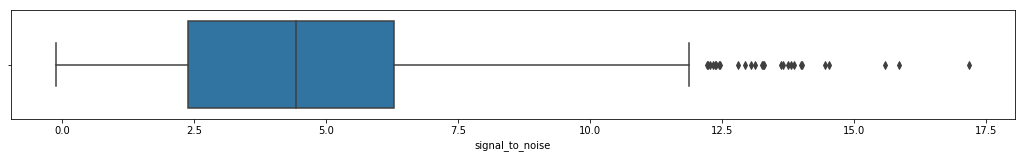

In [34]:
plt.figure(figsize=(18,2))
sns.boxplot(data=train,x='signal_to_noise')

plt.show()

Nous avons également des valeurs négatives de signal / bruit
Nous pouvons également voir des échantillons avec des valeurs de signal / bruit très élevées (pourraient être des valeurs aberrantes potentielles)

In [35]:
print("Nombre d'échantillons avec des valeurs de signal / bruit -ev: ",train[train['signal_to_noise']<0].shape[0])

Q1 = np.percentile(train['signal_to_noise'],q=25)
Q3 = np.percentile(train['signal_to_noise'],q=75)
IQR = Q3 - Q1
print("Nombre d'échantillons avec des valeurs de signal / bruit trop élevées", train[train['signal_to_noise']>Q3+1.5*IQR].shape[0])


Nombre d'échantillons avec des valeurs de signal / bruit -ev:  8
Nombre d'échantillons avec des valeurs de signal / bruit trop élevées 27


In [36]:
train.seq_length.value_counts()

107    2400
Name: seq_length, dtype: int64

Tous les échantillons dans les données de train ont une longueur de 107 séquences

In [37]:
test.seq_length.value_counts()

130    3005
107     629
Name: seq_length, dtype: int64

Les données de test ont à la fois 107 et 130 échantillons de longueur de séquence

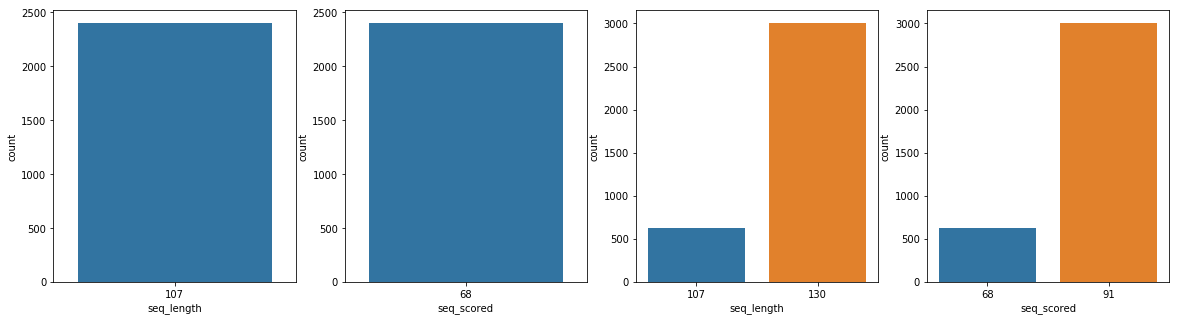

In [38]:
fig, axe = plt.subplots(1, 4, figsize=(20, 5))

sns.countplot(train['seq_length'], ax=axe[0])
sns.countplot(train['seq_scored'], ax=axe[1])
sns.countplot(test['seq_length'], ax=axe[2])
sns.countplot(test['seq_scored'], ax=axe[3])


In [39]:
from typing import Mapping

def apply_seq2id(
    seq: str,
    a_seq2id: Mapping[str,int]
):
    return np.array([a_seq2id[el] for el in seq])

In [40]:
STRUCTURE_CODE = {
    '(': 0, 
    '.': 1, 
    ')': 2
}
STRUCTURE_CODE

{'(': 0, '.': 1, ')': 2}

In [41]:
PREDICTED_LOOP_TYPE_CODE = {
    'H': 0, 
    'E': 1, 
    'B': 2, 
    'M': 3, 
    'X': 4, 
    'S': 5, 
    'I': 6
}
PREDICTED_LOOP_TYPE_CODE

{'H': 0, 'E': 1, 'B': 2, 'M': 3, 'X': 4, 'S': 5, 'I': 6}

In [42]:
SEQUANCE_CODE = {
    'U': 0, 
    'C': 1, 
    'A': 2, 
    'G': 3
}
SEQUANCE_CODE

{'U': 0, 'C': 1, 'A': 2, 'G': 3}

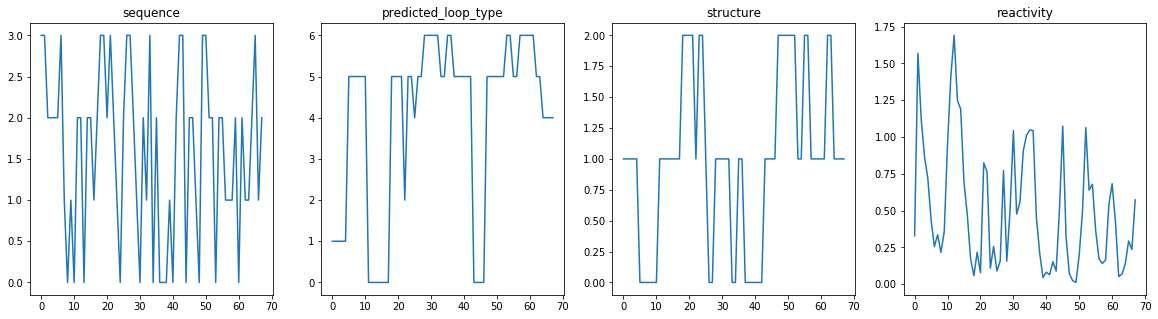

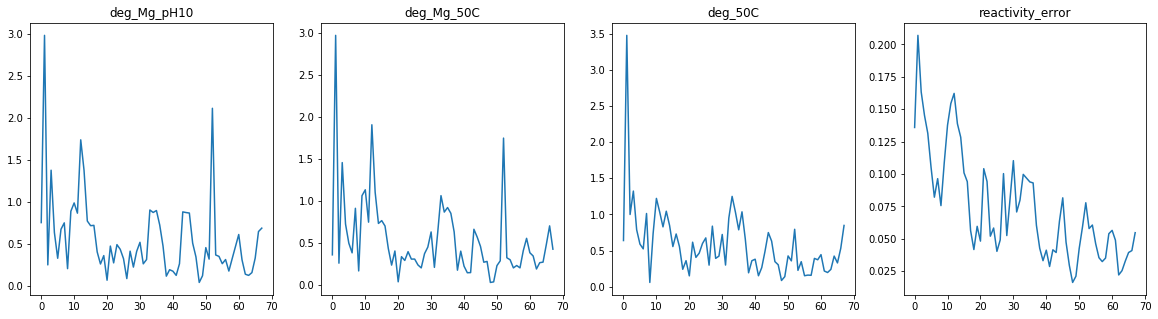

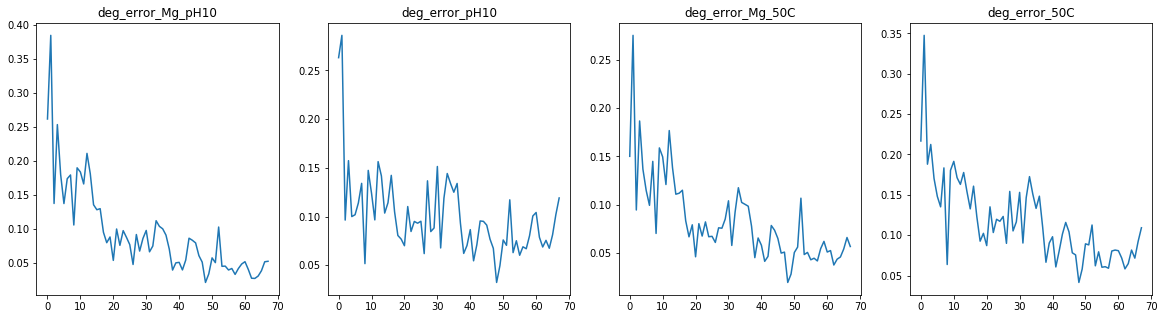

In [43]:
idx = 0

target_len = train.iloc[idx].seq_scored

fig, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.set_title('sequence')
ax1.plot(apply_seq2id(train.iloc[idx].sequence, SEQUANCE_CODE)[:target_len])

ax2.set_title('predicted_loop_type')
ax2.plot(apply_seq2id(train.iloc[idx].predicted_loop_type, PREDICTED_LOOP_TYPE_CODE)[:target_len])

ax3.set_title('structure')
ax3.plot(apply_seq2id(train.iloc[idx].structure, STRUCTURE_CODE)[:target_len])

ax4.set_title('reactivity')
ax4.plot(train.iloc[idx].reactivity[:target_len])

fig1, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.set_title('deg_Mg_pH10')
ax1.plot(train.iloc[idx].deg_Mg_pH10[:target_len])

ax2.set_title('deg_Mg_50C')
ax2.plot(train.iloc[idx].deg_Mg_50C[:target_len])

ax3.set_title('deg_50C')
ax3.plot(train.iloc[idx].deg_50C[:target_len])

ax4.set_title('reactivity_error')
ax4.plot(train.iloc[idx].reactivity_error[:target_len])

fig2, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.set_title('deg_error_Mg_pH10')
ax1.plot(train.iloc[idx].deg_error_Mg_pH10[:target_len])

ax2.set_title('deg_error_pH10')
ax2.plot(train.iloc[idx].deg_error_pH10[:target_len])

ax3.set_title('deg_error_Mg_50C')
ax3.plot(train.iloc[idx].deg_error_Mg_50C[:target_len])

ax4.set_title('deg_error_50C')
ax4.plot(train.iloc[idx].deg_error_50C[:target_len])

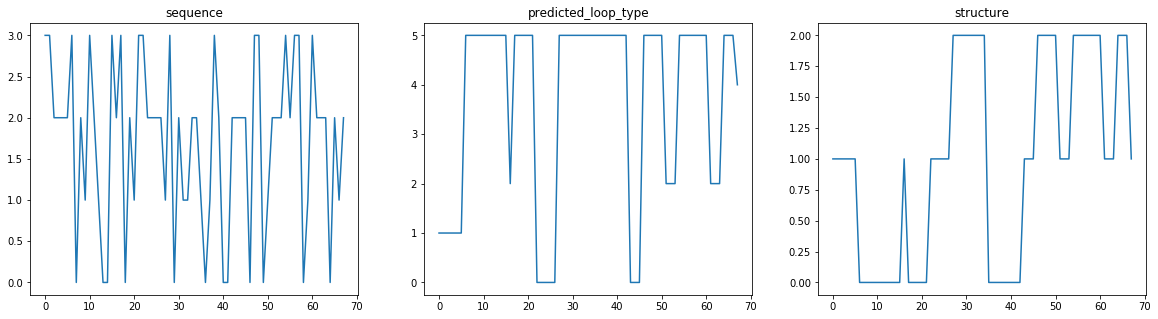

In [44]:
idx = 0

target_len = train.iloc[idx].seq_scored

fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.set_title('sequence')
ax1.plot(apply_seq2id(test.iloc[idx].sequence, SEQUANCE_CODE)[:target_len])

ax2.set_title('predicted_loop_type')
ax2.plot(apply_seq2id(test.iloc[idx].predicted_loop_type, PREDICTED_LOOP_TYPE_CODE)[:target_len])

ax3.set_title('structure')
ax3.plot(apply_seq2id(test.iloc[idx].structure, STRUCTURE_CODE)[:target_len])


In [45]:
all_structures = reduce(lambda x,y: x+y, train['structure'].apply(list).tolist())
all_sequences = reduce(lambda x,y: x+y, train['sequence'].apply(list).tolist())
all_predicted_loop_types = reduce(lambda x,y: x+y, train['predicted_loop_type'].apply(list).tolist())
all_reactivitys = reduce(lambda x,y: x+y, train['reactivity'].apply(list).tolist())
all_deg_Mg_pH10s = reduce(lambda x,y: x+y, train['deg_Mg_pH10'].apply(list).tolist())
all_deg_Mg_50Cs = reduce(lambda x,y: x+y, train['deg_Mg_50C'].apply(list).tolist())
all_deg_50Cs = reduce(lambda x,y: x+y, train['deg_50C'].apply(list).tolist())
all_deg_pH10s = reduce(lambda x,y: x+y, train['deg_pH10'].apply(list).tolist())

(array([3.40000e+01, 1.00000e+00, 1.40000e+01, 3.00000e+01, 2.00750e+04,
        1.42886e+05, 8.40000e+01, 3.10000e+01, 2.00000e+00, 4.30000e+01]),
 array([-4.451530e+01, -3.561165e+01, -2.670800e+01, -1.780435e+01,
        -8.900700e+00,  2.950000e-03,  8.906600e+00,  1.781025e+01,
         2.671390e+01,  3.561755e+01,  4.452120e+01]),
 <a list of 10 Patch objects>)

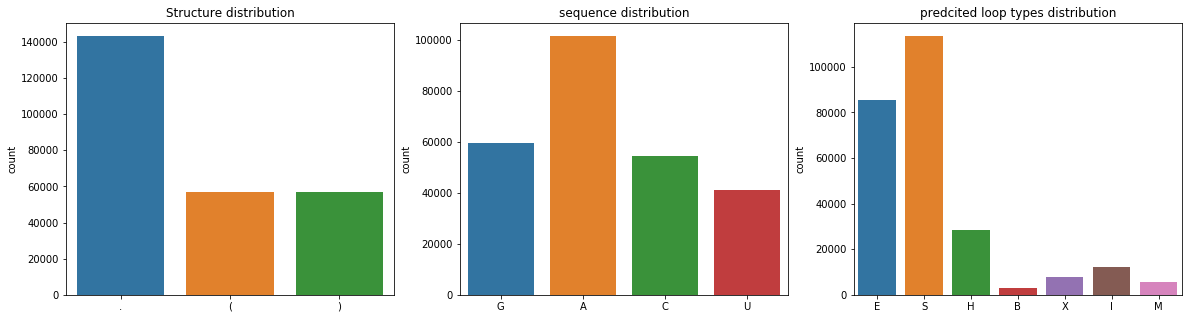

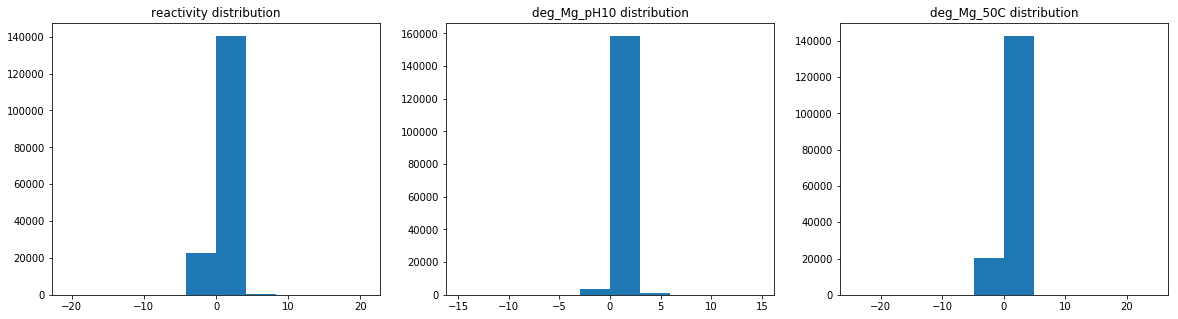

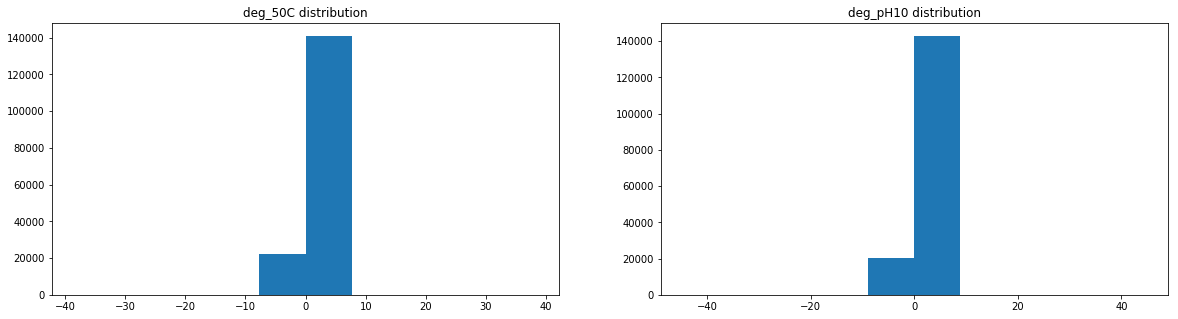

In [46]:
fig1, axe = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(all_structures, ax=axe[0])
sns.countplot(all_sequences, ax=axe[1])
sns.countplot(all_predicted_loop_types, ax=axe[2])

axe[0].set_title('Structure distribution')
axe[1].set_title('sequence distribution');
axe[2].set_title('predcited loop types distribution');

fig2, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.set_title('reactivity distribution')
ax1.hist(all_reactivitys)

ax2.set_title('deg_Mg_pH10 distribution')
ax2.hist(all_deg_Mg_pH10s)

ax3.set_title('deg_Mg_50C distribution')
ax3.hist(all_deg_Mg_50Cs)

fig3, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.set_title('deg_50C distribution')
ax1.hist(all_deg_50Cs)

ax2.set_title('deg_pH10 distribution')
ax2.hist(all_deg_pH10s)


In [47]:
all_structures = reduce(lambda x,y: x+y, test['structure'].apply(list).tolist())
all_sequences = reduce(lambda x,y: x+y, test['sequence'].apply(list).tolist())
all_predicted_loop_types = reduce(lambda x,y: x+y, test['predicted_loop_type'].apply(list).tolist())

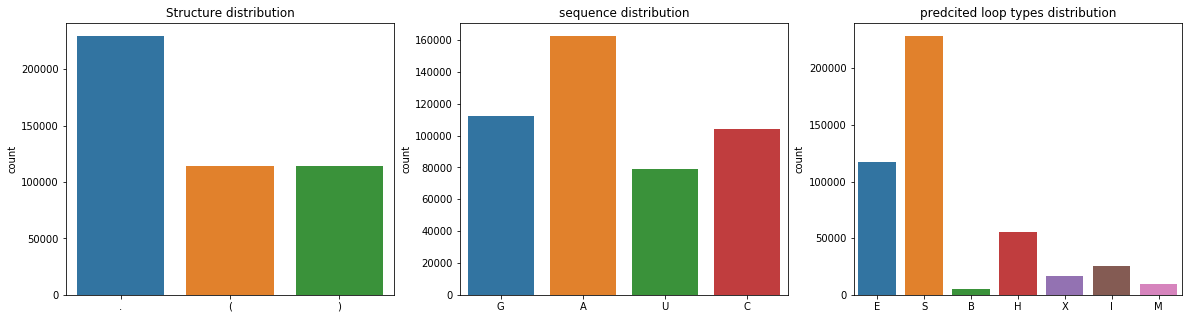

In [48]:
fig1, axe = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(all_structures, ax=axe[0])
sns.countplot(all_sequences, ax=axe[1])
sns.countplot(all_predicted_loop_types, ax=axe[2])

axe[0].set_title('Structure distribution')
axe[1].set_title('sequence distribution')
axe[2].set_title('predcited loop types distribution');

In [49]:
avg_reactivity = np.array(list(map(np.array,train.reactivity))).mean(axis=0)
avg_deg_50C = np.array(list(map(np.array,train.deg_50C))).mean(axis=0)
avg_deg_pH10 = np.array(list(map(np.array,train.deg_pH10))).mean(axis=0)
avg_deg_Mg_50C = np.array(list(map(np.array,train.deg_Mg_50C))).mean(axis=0)
avg_deg_Mg_pH10 = np.array(list(map(np.array,train.deg_Mg_pH10))).mean(axis=0)

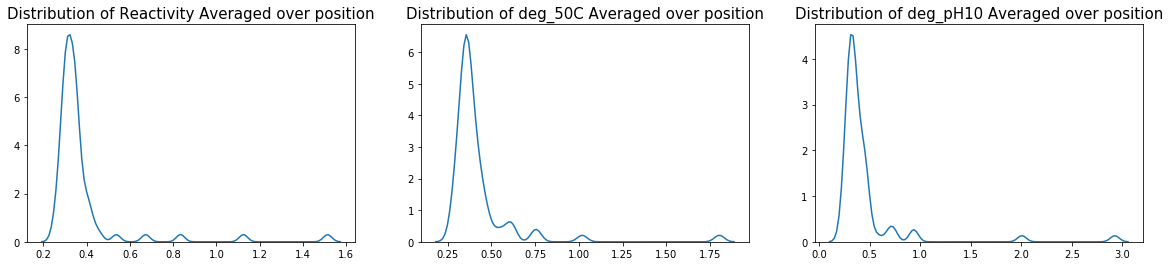

In [50]:
fig, ax = plt.subplots(1,3,figsize=(20,4))

sns.kdeplot(avg_reactivity,ax=ax[0])
ax[0].set_title('Distribution of Reactivity Averaged over position',size=15)

sns.kdeplot(avg_deg_50C,ax=ax[1])
ax[1].set_title('Distribution of deg_50C Averaged over position',size=15)

sns.kdeplot(avg_deg_pH10,ax=ax[2])
ax[2].set_title('Distribution of deg_pH10 Averaged over position',size=15)


plt.show()

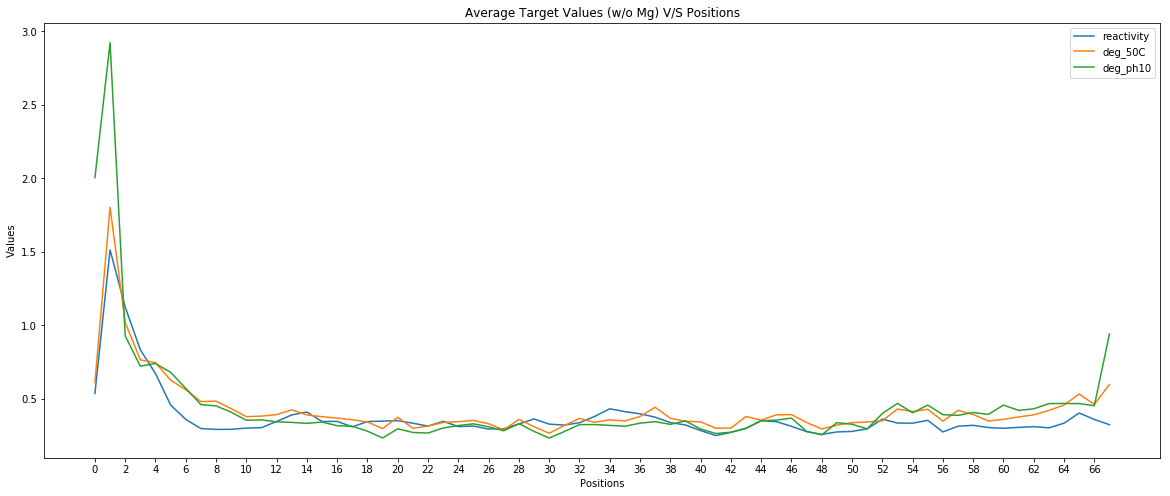

In [51]:
plt.figure(figsize=(20,8))

sns.lineplot(x=range(68),y=avg_reactivity,label='reactivity')
sns.lineplot(x=range(68),y=avg_deg_50C,label='deg_50C')
sns.lineplot(x=range(68),y=avg_deg_pH10,label='deg_ph10')

plt.xlabel('Positions')
plt.xticks(range(0,68,2))
plt.ylabel('Values')
plt.title('Average Target Values (w/o Mg) V/S Positions')

plt.show()

Nous pouvons voir des valeurs élevées de dégradation et de réactivité au début de la séquence
Il y a une forte dégradation à cause du pH 10 au début mais pas de modèle pour le reste des positions.
Nous pouvons voir une corrélation entre deg_50C et deg_pH10

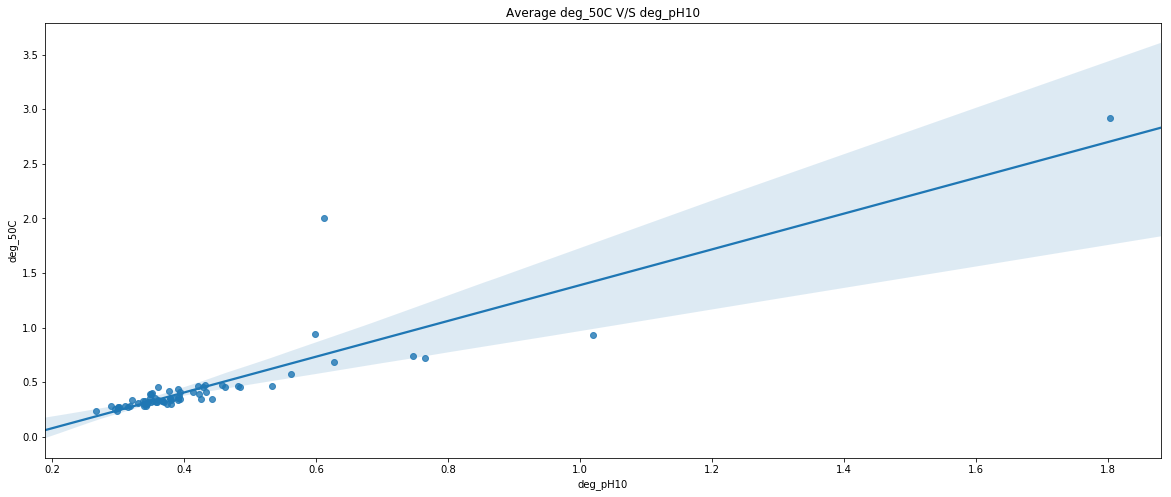

In [52]:
plt.figure(figsize=(20,8))
sns.regplot(x=avg_deg_50C,y=avg_deg_pH10)

plt.title('Average deg_50C V/S deg_pH10')
plt.ylabel('deg_50C')
plt.xlabel('deg_pH10')

plt.show()

In [53]:
print("Correlation Coeff between avg_deg_50C & avg_deg_pH10: ",np.corrcoef(avg_deg_50C,avg_deg_pH10)[0][1])

Correlation Coeff between avg_deg_50C & avg_deg_pH10:  0.8841301466799286


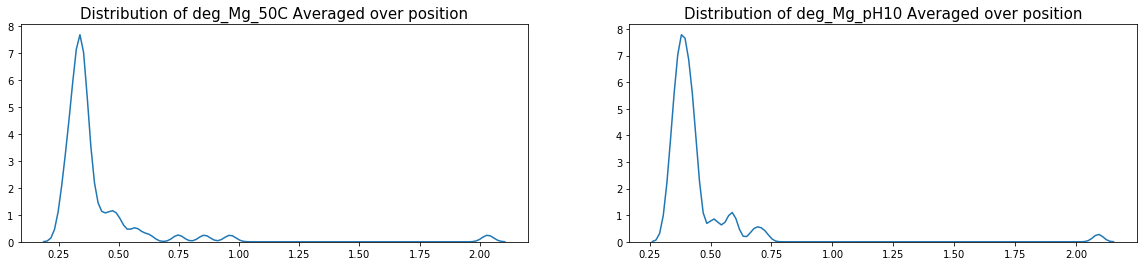

In [54]:
fig, ax = plt.subplots(1,2,figsize=(20,4))

sns.kdeplot(avg_deg_Mg_50C,ax=ax[0])
ax[0].set_title('Distribution of deg_Mg_50C Averaged over position',size=15)


sns.kdeplot(avg_deg_Mg_pH10,ax=ax[1])
ax[1].set_title('Distribution of deg_Mg_pH10 Averaged over position',size=15)

plt.show()

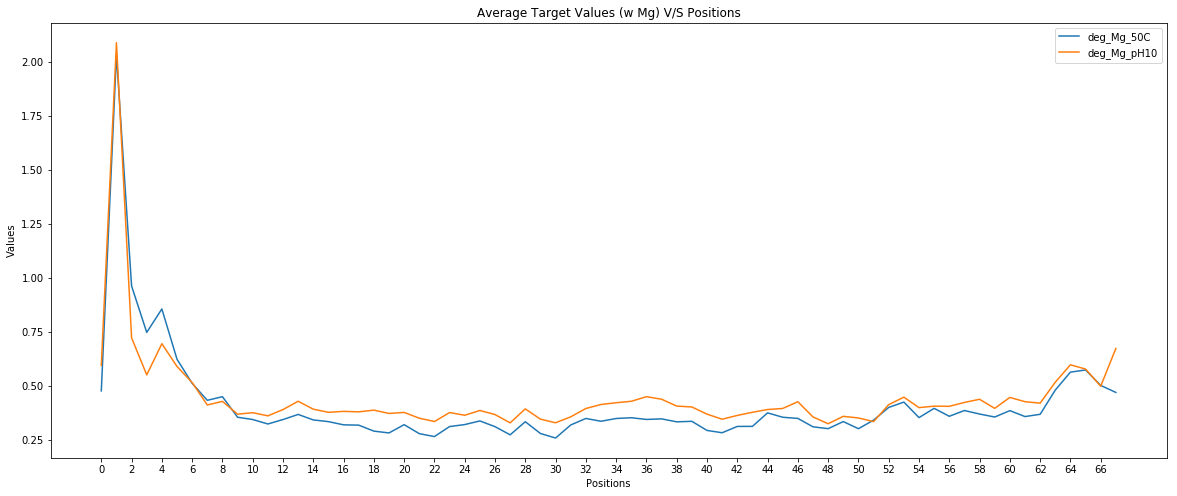

In [55]:
plt.figure(figsize=(20,8))

sns.lineplot(x=range(68),y=avg_deg_Mg_50C,label='deg_Mg_50C')
sns.lineplot(x=range(68),y=avg_deg_Mg_pH10,label='deg_Mg_pH10')

plt.xlabel('Positions')
plt.xticks(range(0,68,2))
plt.ylabel('Values')
plt.title('Average Target Values (w Mg) V/S Positions')

plt.show()

La plupart du temps, deg_Mg_pH10 est supérieur à deg_Mg_50C
Et nous pouvons voir une corrélation entre eux

In [56]:
print("Coeff de corrélation entre avg_deg_Mg_50C et avg_deg_Mg_pH10: ",np.corrcoef(avg_deg_Mg_50C,avg_deg_Mg_pH10)[0][1])

Coeff de corrélation entre avg_deg_Mg_50C et avg_deg_Mg_pH10:  0.9651712822435524


deg_Mg_50C et deg_Mg_pH10 sont fortement corrélés

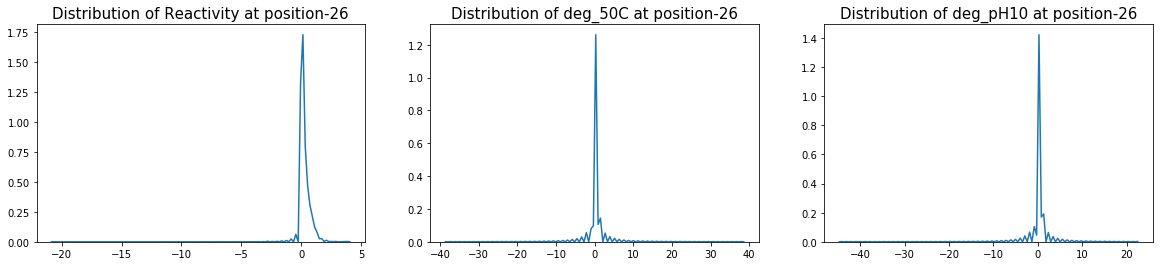

In [57]:
pos = np.random.choice(68)

fig, ax = plt.subplots(1,3,figsize=(20,4))

sns.kdeplot(np.array(list(map(np.array,train.reactivity)))[:,pos],ax=ax[0])
ax[0].set_title(f'Distribution of Reactivity at position-{pos}',size=15)

sns.kdeplot(np.array(list(map(np.array,train.deg_50C)))[:,pos],ax=ax[1])
ax[1].set_title(f'Distribution of deg_50C at position-{pos}',size=15)

sns.kdeplot(np.array(list(map(np.array,train.deg_pH10)))[:,pos],ax=ax[2])
ax[2].set_title(f'Distribution of deg_pH10 at position-{pos}',size=15)

plt.show()

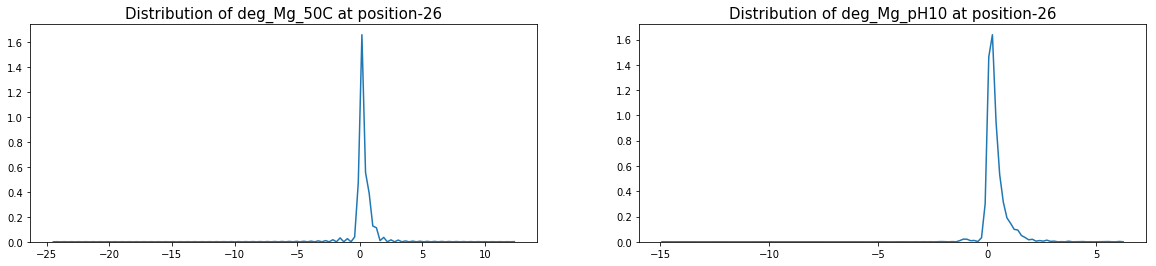

In [58]:
fig, ax = plt.subplots(1,2,figsize=(20,4))

sns.kdeplot(np.array(list(map(np.array,train.deg_Mg_50C)))[:,pos],ax=ax[0])
ax[0].set_title(f'Distribution of deg_Mg_50C at position-{pos}',size=15)

sns.kdeplot(np.array(list(map(np.array,train.deg_Mg_pH10)))[:,pos],ax=ax[1])
ax[1].set_title(f'Distribution of deg_Mg_pH10 at position-{pos}',size=15)

plt.show()

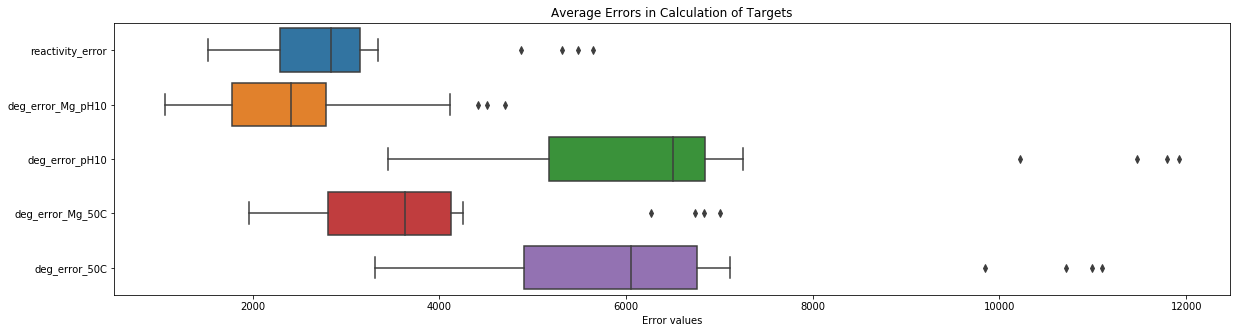

In [59]:
y = ['reactivity_error','deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C','deg_error_50C']
x = [np.array(list(map(np.array,train[col]))).mean(axis=0) for col in y]

plt.figure(figsize=(20,5))

sns.boxplot(y=y,x=x)

plt.xlabel('Error values')
plt.title('Average Errors in Calculation of Targets')

plt.show()

Valeurs très élevées d'erreurs dans deg_error_pH10 & deg_error_50C mais peut-être ne devrions-nous pas nous soucier de ces cibles car l'évaluation n'est pas basée sur ces cibles
Peut-être que cela pourrait être une raison pour laquelle nos modèles ne seront pas marqués sur ces deux cibles

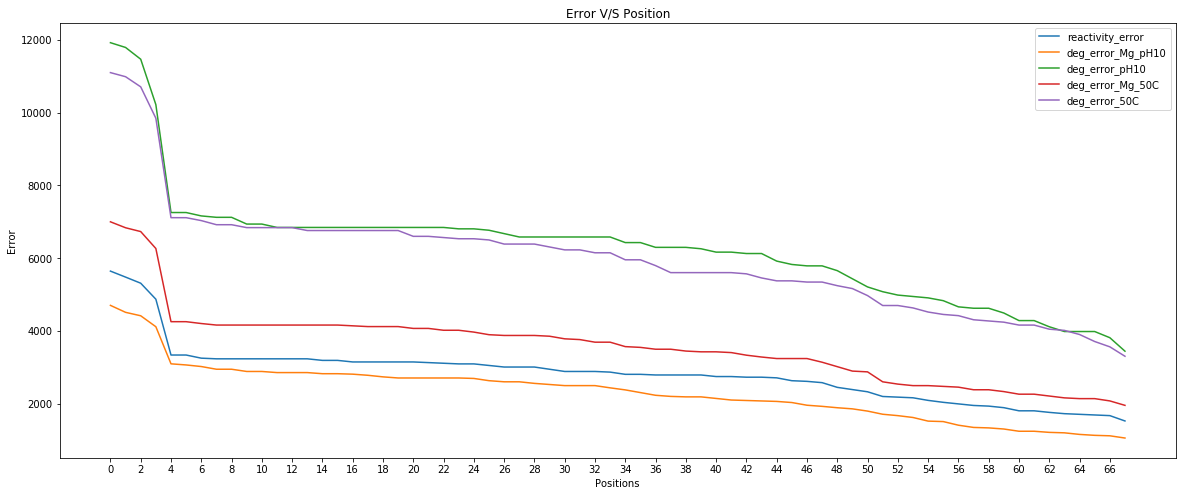

In [60]:
plt.figure(figsize=(20,8))

for i in range(len(y)):
    sns.lineplot(x=range(68),y=x[i],label=y[i])
    
plt.xlabel('Positions')
plt.xticks(range(0,68,2))
plt.ylabel('Error')
plt.title('Error V/S Position')

plt.show()


Nous pouvons voir un modèle intéressant ici. Nous avons des valeurs d'erreurs élevées entre les positions 0 et 4, mais ensuite cela commence à diminuer constamment au fur et à mesure que nous avançons
Analysons maintenant si tous les échantillons contribuent à ces valeurs élevées ou s'il n'y a que quelques fragments qui génèrent ces valeurs

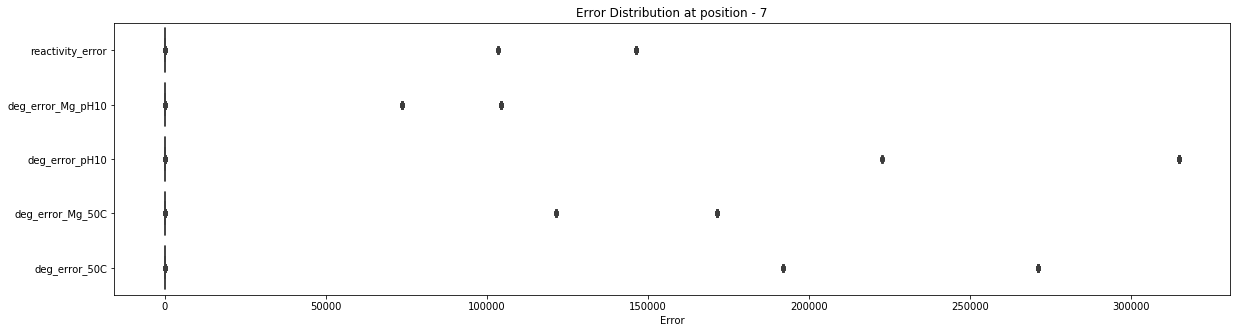

In [61]:
pos = np.random.choice(68)

y = ['reactivity_error','deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C','deg_error_50C']
x = [np.array(list(map(np.array,train[col])))[:,pos] for col in y]

plt.figure(figsize=(20,5))
plt.title(f'Error Distribution at position - {pos}')
plt.xlabel('Error')

sns.boxplot(y=y,x=x)

plt.show()

Nous pouvons voir que peu d'échantillons ont des valeurs d'erreurs élevées
Essayons maintenant de filtrer ces échantillons
Nous pouvons essayer d'utiliser SN_filter pour cela

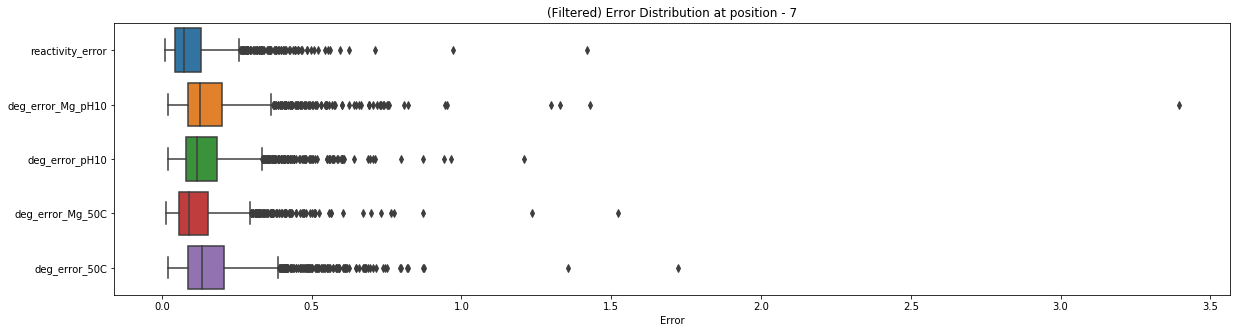

In [62]:
y = ['reactivity_error','deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C','deg_error_50C']
x = [np.array(list(map(np.array,train[train.SN_filter==1][col])))[:,pos] for col in y]

plt.figure(figsize=(20,5))
plt.title(f'(Filtered) Error Distribution at position - {pos}')
plt.xlabel('Error')

sns.boxplot(y=y,x=x)

plt.show()

Les échantillons avec SN_filter = 1 ont de faibles valeurs d'erreurs
Nous pouvons utiliser ce filtre pour entraîner notre modèle uniquement sur ces échantillons, mais comme les données de test privées ne sont pas filtrées, cela pourrait ne donner de bons résultats que sur Public LB mais pas sur Private LB

In [63]:
One_sample = train.iloc[0]
One_sequence = One_sample["sequence"]
One_structure = One_sample["structure"]
One_predicted_loop_type = One_sample["predicted_loop_type"]
One_reactivity = One_sample["reactivity"]

sequence - (1x107 string dans Train and Public Test, 130 in Private Test) Décrit la séquence d'ARN, une combinaison de A, G, U et C pour chaque échantillon. Doit contenir 107 caractères et les 68 premières bases doivent correspondre aux 68 positions spécifiées dans seq_scored (note: indexées à partir de 0).

In [64]:
collections.Counter(One_sequence)

Counter({'G': 19, 'A': 45, 'C': 23, 'U': 20})

In [65]:
sum_one_sequence = sum(collections.Counter(One_sequence).values())
sum_one_sequence

107

structure - (chaîne 1x107 dans Train et Test public, 130 dans Test privé) Un tableau de (,) et. caractères qui décrivent si une base est estimée être appariée ou non appariée. Les bases appariées sont indiquées par des parenthèses ouvrantes et fermantes, par ex. (....) signifie que la base 0 est appariée à la base 5 et que les bases 1-4 ne sont pas appariées.

In [66]:
collections.Counter(One_structure)

Counter({'.': 61, '(': 23, ')': 23})

In [67]:
sum_one_structure = sum(collections.Counter(One_structure).values())
sum_one_structure

107

Predicted_loop_type - (1x107 string) Décrit le contexte structurel (également appelé «type de boucle») de chaque caractère dans la séquence. Types de boucles attribués par bpRNA de la structure Vienna RNAfold 2. À partir de la documentation bpRNA_documentation: S: "Tige" appariée M: Boucle multiple I: Boucle interne B: Renflement H: Boucle en épingle à cheveux E: extrémité pendante X: Boucle externe

In [68]:
collections.Counter(One_predicted_loop_type)

Counter({'E': 26, 'S': 46, 'H': 15, 'B': 1, 'X': 5, 'I': 14})

In [69]:
sum_one_predicted_loop_type = sum(collections.Counter(One_predicted_loop_type).values())
sum_one_predicted_loop_type

107

## <span style='color:Blue'> FEATURE ENGINEERING </span>

Features Engineering est un processus de sélection et de transformation de variables lors de la création d'un modèle prédictif à l'aide de l'apprentissage automatique ou de la modélisation statistique (comme l'apprentissage en profondeur, les arbres de décision
ou la régression). 
Le processus implique une combinaison d'analyse de données, d'application de règles empiriques et de jugement. Il est parfois appelé prétraitement.

In [70]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

Le dossier bpps contient les matrices des probabilités d'appariement de base pour chaque séquence. Ces matrices donnent la probabilité que chaque paire de nucléotides dans l'ARN forme une paire de bases. Chaque matrice est une matrice carrée symétrique de la même longueur que la séquence.

In [71]:
def read_bpps_sum(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"{path_npy}{mol_id}.npy").sum(axis=1))
    return bpps_arr

In [72]:
def read_bpps_max(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"{path_npy}{mol_id}.npy").max(axis=1))
    return bpps_arr

In [73]:
def read_bpps_nb(df):
    bpps_nb_mean = 0.077522
    bpps_nb_std = 0.08914
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps = np.load(f"{path_npy}{mol_id}.npy")
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        bpps_arr.append(bpps_nb)
    return bpps_arr

In [74]:
train['bpps_sum'] = read_bpps_sum(train)
train['bpps_max'] = read_bpps_max(train)
train['bpps_nb'] = read_bpps_nb(train)

In [75]:
test['bpps_sum'] = read_bpps_sum(test)
test['bpps_max'] = read_bpps_max(test)
test['bpps_nb'] = read_bpps_nb(test)

In [76]:
train[train.columns[-3:]].head()

bpps_sum  \
0  [0.19854229, 0.18371220000000002, 0.0600024000...   
1  [0.16883627604054915, 0.10675940059456464, 0.0...   
2  [0.06680724164624499, 0.04433748694733778, 0.0...   
3  [0.22702912000000003, 0.18439387000000002, 0.0...   
4  [0.04036075455181073, 0.08021642791992274, 0.0...   

                                            bpps_max  \
0  [0.0217857, 0.0386527, 0.0275904, 0.00947066, ...   
1  [0.11931483477784201, 0.0808186531761711, 0.06...   
2  [0.017340043515196805, 0.00826566577930985, 0....   
3  [0.0350158, 0.0332295, 0.00272567, 0.0, 0.0, 0...   
4  [0.02230060114516417, 0.052274223411953764, 0....   

                                             bpps_nb  
0  [2.0659663786252436, 1.2272143577570933, -0.34...  
1  [0.49330633949746183, 0.49330633949746183, -0....  
2  [2.275654383842281, 2.5901863916678374, 0.8078...  
3  [0.5981503421059805, 0.9126823499315369, -0.65...  
4  [0.5981503421059805, 0.8078383473230181, 0.178...

In [77]:
len(train[train.columns[-3]][0])

107

In [78]:
test[test.columns[-3:]].head()

bpps_sum  \
0  [0.03701574756330438, 0.012454753930743238, 0....   
1  [0.2304712272461556, 0.23820549694391135, 0.20...   
2  [0.07493084, 0.02550902, 0.0, 0.00150035, 0.00...   
3  [0.15362639758779065, 0.2281113621902515, 0.12...   
4  [0.019419062344993222, 0.005454117834146501, 3...   

                                            bpps_max  \
0  [0.007221606518561295, 0.002257620678109476, 0...   
1  [0.193407103672755, 0.19773924317365849, 0.195...   
2  [0.0294548, 0.00763603, 0.0, 0.00150035, 0.001...   
3  [0.06724628826674545, 0.12075529229189887, 0.1...   
4  [0.004852784769972624, 0.001329212597223424, 3...   

                                             bpps_nb  
0  [0.9126823499315369, 1.2272143577570933, 0.178...  
1  [0.3384598125679572, 0.5973438497782229, -0.26...  
2  [0.388462336888943, -0.030913673545132192, -0....  
3  [0.388462336888943, 0.2836183342804242, -0.555...  
4  [-0.17930826185257406, -0.17930826185257406, -...

In [79]:
len(test[test.columns[-3]][0])

107

In [80]:
train_set = train.copy()
test_set = test.copy()

In [81]:
train_json = train_set.to_json(orient='table')
test_json = test_set.to_json(orient='table')

In [82]:
train_json = json.loads(train_json)
test_json = json.loads(test_json)
train_json = train_json["data"]
test_json = test_json["data"]

In [83]:
for line in train_json:
    line['step'] = list(range(line['seq_scored']))
    line['sequence'] = list(line['sequence'])
    line['structure'] = list(line['structure'])
    line['predicted_loop_type'] = list(line['predicted_loop_type'])

In [84]:
df_data_train_set = pd.json_normalize(data = train_json, 
                            record_path ='reactivity',  
                            meta =['id','signal_to_noise',
                                  'SN_filter','seq_length','seq_scored']) 
df_data_train_set.rename(columns={0:'reactivity'}, inplace=True)
df_data_train_set['step'] = pd.json_normalize(data = train_json, record_path ='step')
df_data_train_set['sequence'] = pd.json_normalize(data = train_json, record_path ='sequence')
df_data_train_set['structure'] = pd.json_normalize(data = train_json, record_path ='structure')
df_data_train_set['predicted_loop_type'] = pd.json_normalize(data = train_json, record_path ='predicted_loop_type')
df_data_train_set['reactivity_error'] = pd.json_normalize(data = train_json, record_path ='reactivity_error')
df_data_train_set['deg_Mg_pH10'] = pd.json_normalize(data = train_json, record_path ='deg_Mg_pH10')
df_data_train_set['deg_error_Mg_pH10'] = pd.json_normalize(data = train_json, record_path ='deg_error_Mg_pH10')
df_data_train_set['deg_pH10'] = pd.json_normalize(data = train_json, record_path ='deg_pH10')
df_data_train_set['deg_error_pH10'] = pd.json_normalize(data = train_json, record_path ='deg_error_pH10')
df_data_train_set['deg_Mg_50C'] = pd.json_normalize(data = train_json, record_path ='deg_Mg_50C')
df_data_train_set['deg_error_Mg_50C'] = pd.json_normalize(data = train_json, record_path ='deg_error_Mg_50C')
df_data_train_set['deg_50C'] = pd.json_normalize(data = train_json, record_path ='deg_50C')
df_data_train_set['deg_error_50C'] = pd.json_normalize(data = train_json, record_path ='deg_error_50C')
df_data_train_set['bpps_sum'] = pd.json_normalize(data = train_json, record_path ='bpps_sum')
df_data_train_set['bpps_max'] = pd.json_normalize(data = train_json, record_path ='bpps_max')
df_data_train_set['bpps_nb'] = pd.json_normalize(data = train_json, record_path ='bpps_nb')

df_data_train_set.set_index(['id','step'], inplace=True)

In [85]:
df_data_train_set.head()

reactivity signal_to_noise SN_filter seq_length seq_scored  \
id           step                                                               
id_001f94081 0         0.3297           6.894         1        107         68   
             1         1.5693           6.894         1        107         68   
             2         1.1227           6.894         1        107         68   
             3         0.8686           6.894         1        107         68   
             4         0.7217           6.894         1        107         68   

                  sequence structure predicted_loop_type  reactivity_error  \
id           step                                                            
id_001f94081 0           G         .                   E            0.1359   
             1           G         .                   E            0.2070   
             2           A         .                   E            0.1633   
             3           A         .                   E            0.1452   
             4           A         .                   E            0.1314   

                   deg_Mg_pH10  deg_error_Mg_pH10  deg_pH10  deg_error_pH10  \
id           step                                                             
id_001f94081 0          0.7556             0.2613    2.3375          0.2631   
             1          2.9830             0.3842    3.5060          0.2860   
             2          0.2526             0.1372    0.3008          0.0964   
             3          1.3789             0.2531    1.0108          0.1574   
             4          0.6376             0.1798    0.2635          0.1000   

                   deg_Mg_50C  deg_error_Mg_50C  deg_50C  deg_error_50C  \
id           step                                                         
id_001f94081 0         0.3581            0.1501   0.6382         0.2167   
             1         2.9683            0.2750   3.4773         0.3475   
             2         0.2589            0.0947   0.9988         0.1880   
             3         1.4552            0.1866   1.3228         0.2124   
             4         0.7244            0.1369   0.7877         0.1703   

                   bpps_sum  bpps_max   bpps_nb  
id           step                                
id_001f94081 0     0.198542  0.021786  2.065966  
             1     0.183712  0.038653  1.227214  
             2     0.060002  0.027590 -0.345446  
             3     0.013122  0.009471 -0.450290  
             4     0.011280  0.007029 -0.555134

In [86]:
for line in test_json:
    line['step'] = list(range(line['seq_scored']))
    line['sequence'] = list(line['sequence'])
    line['structure'] = list(line['structure'])
    line['predicted_loop_type'] = list(line['predicted_loop_type'])

In [87]:
df_data_test_set = pd.json_normalize(data = test_json,
                         record_path = 'sequence',
                        meta = ['id','seq_length','seq_scored'])
df_data_test_set.rename(columns={0:'sequence'},inplace=True)
df_data_test_set['step'] = pd.json_normalize(data = test_json,record_path = 'step')
df_data_test_set['sequence'] = pd.json_normalize(data = test_json,record_path = 'sequence')
df_data_test_set['structure'] = pd.json_normalize(data = test_json,record_path = 'structure')
df_data_test_set['predicted_loop_type'] = pd.json_normalize(data = test_json,record_path = 'predicted_loop_type')
df_data_test_set['bpps_sum'] = pd.json_normalize(data = test_json, record_path ='bpps_sum')
df_data_test_set['bpps_max'] = pd.json_normalize(data = test_json, record_path ='bpps_max')
df_data_test_set['bpps_nb'] = pd.json_normalize(data = test_json, record_path ='bpps_nb')

df_data_test_set.set_index(['id','step'], inplace=True)

In [88]:
public_test_df = df_data_test_set.query("seq_length == 107").copy()
private_test_df = df_data_test_set.query("seq_length == 130").copy()

In [89]:
public_test_df.head(3)

sequence seq_length seq_scored structure  \
id           step                                            
id_00073f8be 0.0         G        107         68         .   
             1.0         G        107         68         .   
             2.0         A        107         68         .   

                  predicted_loop_type  bpps_sum  bpps_max   bpps_nb  
id           step                                                    
id_00073f8be 0.0                    E  0.037016  0.007222  0.912682  
             1.0                    E  0.012455  0.002258  1.227214  
             2.0                    E  0.002620  0.001221  0.178774

In [90]:
private_test_df.head(3)

sequence seq_length seq_scored structure  \
id           step                                            
id_000ae4237 39.0        G        130         91         .   
             40.0        G        130         91         .   
             41.0        A        130         91         .   

                  predicted_loop_type  bpps_sum  bpps_max   bpps_nb  
id           step                                                    
id_000ae4237 39.0                   E  0.230471  0.193407  0.338460  
             40.0                   E  0.238205  0.197739  0.597344  
             41.0                   E  0.203814  0.195325 -0.265603

### <span style='color:Green'> ENCODAGE DATA </span>

En utilisant labelencoder et OneHotEncoder nous allons appliquer la transformation des données et de passer de variables cat vers des valeurs discrètes.

In [91]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import copy

In [92]:
Encoding = LabelEncoder()
quantitative_train = [cols for cols in df_data_train_set.columns if df_data_train_set[cols].dtype == 'object']
quantitative_test = [cols for cols in df_data_test_set.columns if df_data_test_set[cols].dtype == 'object']
df_train_set_encode = copy.deepcopy(df_data_train_set)
df_test_set_encode = copy.deepcopy(df_data_test_set)
for cols in quantitative_train:
        df_train_set_encode[cols] = Encoding.fit_transform(df_train_set_encode[cols])
for cols in quantitative_test:
        df_test_set_encode[cols] = Encoding.fit_transform(df_test_set_encode[cols])

In [93]:
df_train_set_encode.head(3)

reactivity  signal_to_noise  SN_filter  seq_length  \
id           step                                                       
id_001f94081 0         0.3297             1602          1           0   
             1         1.5693             1602          1           0   
             2         1.1227             1602          1           0   

                   seq_scored  sequence  structure  predicted_loop_type  \
id           step                                                         
id_001f94081 0              0         2          2                    1   
             1              0         2          2                    1   
             2              0         0          2                    1   

                   reactivity_error  deg_Mg_pH10  deg_error_Mg_pH10  deg_pH10  \
id           step                                                               
id_001f94081 0               0.1359       0.7556             0.2613    2.3375   
             1               0.2070       2.9830             0.3842    3.5060   
             2               0.1633       0.2526             0.1372    0.3008   

                   deg_error_pH10  deg_Mg_50C  deg_error_Mg_50C  deg_50C  \
id           step                                                          
id_001f94081 0             0.2631      0.3581            0.1501   0.6382   
             1             0.2860      2.9683            0.2750   3.4773   
             2             0.0964      0.2589            0.0947   0.9988   

                   deg_error_50C  bpps_sum  bpps_max   bpps_nb  
id           step                                               
id_001f94081 0            0.2167  0.198542  0.021786  2.065966  
             1            0.3475  0.183712  0.038653  1.227214  
             2            0.1880  0.060002  0.027590 -0.345446

In [94]:
df_test_set_encode.head(3)

sequence  seq_length  seq_scored  structure  \
id           step                                                
id_00073f8be 0.0          2           0           0          2   
             1.0          2           0           0          2   
             2.0          0           0           0          2   

                   predicted_loop_type  bpps_sum  bpps_max   bpps_nb  
id           step                                                     
id_00073f8be 0.0                     1  0.037016  0.007222  0.912682  
             1.0                     1  0.012455  0.002258  1.227214  
             2.0                     1  0.002620  0.001221  0.178774

In [95]:
y = df_train_set_encode[target_cols]

## <span style='color:Blue'> MODELING </span>

Un modèle d’apprentissage automatique est un algorithme qu’on applique sur les données déjà traités, en générale il existe deux types de modèles, ceux de Classification et d’autres de Régression.
Pour trouver l’algorithme le plus adéquat à notre problématique, nous allons essayer dans un premier temps tous les algorithmes de classifications : Xgboost, LightGbclassifier, Knn, SVM, Arbre de decision...

In [96]:
list_of_model = []

In [97]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [98]:
rideCV = MultiOutputRegressor(estimator=RidgeCV(alphas = alphas))
lassoCV = MultiOutputRegressor(estimator=LassoCV(alphas = None, cv = 10))
ElasticNet = MultiOutputRegressor(estimator=ElasticNet(alpha=0.01, l1_ratio=0.5))
RandomForest = MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=2, random_state=0))
AdaBoost = MultiOutputRegressor(estimator=AdaBoostRegressor(random_state=0, n_estimators=100))
SVR = MultiOutputRegressor(estimator=SVR(C=1.0, epsilon=0.2))
DecisionTree = MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=3,random_state=0))
KNN = MultiOutputRegressor(estimator=KNeighborsRegressor())

In [99]:
list_of_model = {
                'RandomForest': RandomForest,
                'DecisionTree': DecisionTree,
                'SVR': SVR,
                'KNN': KNN}

In [100]:
columns = df_test_set_encode.columns
columns

Index(['sequence', 'seq_length', 'seq_scored', 'structure',
       'predicted_loop_type', 'bpps_sum', 'bpps_max', 'bpps_nb'],
      dtype='object')

In [101]:
def standard_scale(X_train, X_test):
    preprocessor = StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

In [102]:
def Evalution_model(model, key):
    model.fit(df_train_set_encode[columns], y)
    y_pred = model.predict(df_test_set_encode)
    
    print("{} Performance for training and testing set".format(key))
    print("----------------------------------------------------------------------------")
    print('Score :',model.score(df_train_set_encode[columns], y))
    return y_pred

In [103]:
y_predict = []

In [104]:
y_predict

[]

### <span style='color:Green'> XGboost  </span>

In [105]:
xgb_model = xgb.XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=100, min_child_weight=2, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=0)

In [116]:
xgb_mod = MultiOutputRegressor(estimator=xgb_model)

In [118]:
xgb_mod.fit(df_train_set_encode[columns], y)
pred_final = xgb_mod.predict(df_test_set_encode)

In [119]:
print('Score :',xgb_mod.score(df_train_set_encode[columns], y))

Score : 0.3105757604097513


In [120]:
pred_final.shape

(457953, 5)

In [121]:
pred_final

array([[0.3927194 , 0.24679434, 0.27116278, 0.3940304 , 0.41725728],
       [0.30725384, 0.3934325 , 0.40571165, 0.33636287, 0.3919634 ],
       [0.39680403, 0.3973527 , 0.43954912, 0.42385104, 0.43185613],
       ...,
       [0.34680426, 0.46729502, 0.4678684 , 0.39055032, 0.39314967],
       [0.4170799 , 0.47976038, 0.42425302, 0.44953734, 0.45237434],
       [0.3591133 , 0.43978423, 0.40836528, 0.48153067, 2.4436874 ]],
      dtype=float32)

### <span style='color:Green'> Lasso  </span>

In [123]:
from sklearn.linear_model import Lasso

In [124]:
#Xlasso = df_train_set_encode[columns]

#X_train,X_test,y_train,y_test = train_test_split(Xlasso.index,y,test_size=0.2)
#lasso = Lasso(alpha=0.1, normalize=True)
#lasso.fit(X_train, y)
Lasso_model = Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
 normalize=False, positive=False, precompute=False, random_state=None,
 selection='cyclic', tol=0.0001, warm_start=False)

In [125]:
Lasso_mod = MultiOutputRegressor(estimator=Lasso_model)

In [126]:
Lasso_mod.fit(df_train_set_encode[columns], y)
pred_final = Lasso_mod.predict(df_test_set_encode)

In [127]:
print('Score :',Lasso_mod.score(df_train_set_encode[columns], y))

Score : -0.15644863031179015


### <span style='color:Green'> AdaBoost  </span>

In [106]:
from sklearn.ensemble import AdaBoostRegressor

In [107]:
AdaBoost_model = AdaBoostRegressor()

In [108]:
AdaBoost_mod = MultiOutputRegressor(AdaBoost_model)

In [109]:
AdaBoost_mod.fit(df_train_set_encode[columns], y)
pred_final = AdaBoost_mod.predict(df_test_set_encode)

In [110]:
print('Score :',AdaBoost_mod.score(df_train_set_encode[columns], y))

Score : -0.038698425430032345


### <span style='color:Green'> ElasticNet  </span>

In [111]:
from sklearn.linear_model import ElasticNet

In [112]:
ElasticNet_model = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [113]:
ElasticNet_mod = MultiOutputRegressor(ElasticNet_model)

In [114]:
ElasticNet_mod = MultiOutputRegressor(ElasticNet_model)

In [115]:
ElasticNet_mod.fit(df_train_set_encode[columns], y)
pred_final = ElasticNet_mod.predict(df_test_set_encode)

In [116]:
print('Score :',ElasticNet_mod.score(df_train_set_encode[columns], y))

Score : 2.8603608539956584e-06


### <span style='color:Green'> LGbm Classifier  </span>

In [117]:
from lightgbm import LGBMRegressor

In [118]:
LGBM_model = LGBMRegressor()

In [119]:
LGBM_mod = MultiOutputRegressor(LGBM_model)

In [120]:
LGBM_mod.fit(df_train_set_encode[columns], y)
pred_final = LGBM_mod.predict(df_test_set_encode)

In [121]:
print('Score :',LGBM_mod.score(df_train_set_encode[columns], y))

Score : 0.025207538830664934


### <span style='color:Green'> Logistic Regression  </span>

In [122]:
from sklearn.linear_model import LogisticRegression

In [123]:
Logistic_model = LogisticRegression(solver='liblinear', random_state=0)

In [124]:
Logistic_mod = MultiOutputRegressor(Logistic_model)

In [ ]:
Logistic_mod.fit(df_train_set_encode[columns], y)
pred_final = Logistic_mod.predict(df_test_set_encode)

### <span style='color:Green'> Ridge  </span>

In [128]:
from sklearn.linear_model import Ridge

In [129]:
Ridge_model = Ridge(alpha=0.5)
Ridge_mod = MultiOutputRegressor(estimator=Ridge_model)

In [130]:
Ridge_mod.fit(df_train_set_encode[columns], y)
pred_final = Ridge_mod.predict(df_test_set_encode)

In [131]:
print('Score :',Ridge_mod.score(df_train_set_encode[columns], y))

Score : 6.0348480431238194e-05


### <span style='color:Green'> RandomForest  </span>

In [132]:
from sklearn.ensemble import RandomForestRegressor

In [133]:
RandomForest_model = RandomForestRegressor(n_estimators=20, random_state=0)

In [134]:
RandomForest_mod = MultiOutputRegressor(estimator=RandomForest_model)

In [135]:
RandomForest_mod.fit(df_train_set_encode[columns], y)
pred_final = RandomForest_mod.predict(df_test_set_encode)

In [136]:
print('Score :',RandomForest_mod.score(df_train_set_encode[columns], y))

Score : 0.6993556443477995


### <span style='color:Green'> DecisionTree </span>

In [137]:
from sklearn.tree import DecisionTreeClassifier

In [138]:
decision_tree_model = DecisionTreeClassifier(random_state=0, max_depth=2)

In [139]:
decision_tree_mod = MultiOutputRegressor(estimator=decision_tree_model)

In [140]:
from sklearn import preprocessing
from sklearn import utils

In [141]:
df_train_set_encode2 = df_train_set_encode[columns].copy()
#lab_enc = preprocessing.LabelEncoder()
#encoded = lab_enc.fit_transform(trainingScores)

In [ ]:
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(df_train_set_encode2)

### <span style='color:Green'> SVR </span>

In [150]:
from sklearn.svm import SVR

In [147]:
SVR_model = SVR(kernel='rbf', degree=3, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=- 1)

In [148]:
SVR_mod = MultiOutputRegressor(estimator=SVR_model)

In [ ]:
SVR_mod.fit(df_train_set_encode[columns], y)
pred_final = SVR_mod.predict(df_test_set_encode)

### <span style='color:Green'> KNN </span>

In [142]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)

In [143]:
knn_mod = MultiOutputRegressor(estimator=knn_model)

In [ ]:
knn_mod.fit(df_train_set_encode[columns], y)
pred_final = knn_mod.predict(df_test_set_encode)

## <span style='color:Blue'> Deep Learning </span>

seq_scored - (68 en train et test public, 91 en test privé).

Valeur entière indiquant le nombre de positions utilisées dans la notation avec des valeurs prédites.

Cela doit correspondre à la longueur des colonnes de réactivité, deg_ * et * _error_ *

In [33]:
print("Unique values & no. of occurences for seq_scored in the training dataset:\n",train.seq_scored.value_counts())
print("\nUnique values & no. of occurences for seq_scored in the test dataset:\n",test.seq_scored.value_counts())

Unique values & no. of occurences for seq_scored in the training dataset:
 68    2400
Name: seq_scored, dtype: int64

Unique values & no. of occurences for seq_scored in the test dataset:
 91    3005
68     629
Name: seq_scored, dtype: int64


La matrice de probabilité d'appariement de bases (bpps) contient des données précieuses sur des structures d'ARN alternatives mais n'est pas dans un format de séquence 1D. Nous allons extraire plusieurs fonctionnalités qui sont des séquences.

In [63]:
# read npy data file
bpps_dir = 'D:/telechargement/stanford-covid-vaccine/bpps/'
bpps_list = os.listdir(bpps_dir)
bpps_npy = np.load(f'D:/telechargement/stanford-covid-vaccine/bpps/{bpps_list[25]}')
print('Count of npy files: ', len(bpps_list))
print('Size of image: ', bpps_npy.shape)

Count of npy files:  6034
Size of image:  (130, 130)


In [66]:
targets = ['reactivity','deg_Mg_pH10','deg_Mg_50C','deg_pH10','deg_50C']

In [67]:
train = train[['id']+targets ]

In [103]:
train['reactivity'] = train['reactivity'].apply(lambda x: np.mean(x))
train['deg_Mg_pH10'] = train['deg_Mg_pH10'].apply(lambda x: np.mean(x))
train['deg_Mg_50C'] = train['deg_Mg_50C'].apply(lambda x: np.mean(x))
train['deg_pH10'] = train['deg_pH10'].apply(lambda x: np.mean(x))
train['deg_50C'] = train['deg_50C'].apply(lambda x: np.mean(x))

In [34]:
# training dataset
deg_columns = ['reactivity','deg_error_Mg_pH10', 'deg_error_pH10','deg_error_Mg_50C', 'deg_error_50C', 'deg_Mg_pH10','deg_pH10', 'deg_Mg_50C', 'deg_50C']

for col in deg_columns:
    length = []
    for each in range(train.shape[0]):
        length.append(len(train[col].iloc[each]))

    print("Length of different values for " + col + " in training dataset:",set(length))

Length of different values for reactivity in training dataset: {68}
Length of different values for deg_error_Mg_pH10 in training dataset: {68}
Length of different values for deg_error_pH10 in training dataset: {68}
Length of different values for deg_error_Mg_50C in training dataset: {68}
Length of different values for deg_error_50C in training dataset: {68}
Length of different values for deg_Mg_pH10 in training dataset: {68}
Length of different values for deg_pH10 in training dataset: {68}
Length of different values for deg_Mg_50C in training dataset: {68}
Length of different values for deg_50C in training dataset: {68}


In [35]:
print("Unique values & there occurences for seq_length in the training dataset:\n",train.seq_length.value_counts())
print("\nUnique values & there occurences for seq_length in the test dataset:\n",test.seq_length.value_counts())

Unique values & there occurences for seq_length in the training dataset:
 107    2400
Name: seq_length, dtype: int64

Unique values & there occurences for seq_length in the test dataset:
 130    3005
107     629
Name: seq_length, dtype: int64


In [60]:
# training dataset
length = []
for each in range(train.shape[0]):
    length.append(len(train.sequence.iloc[each]))

print("length of different values for sequence in training dataset:",set(length))

# test dataset
length = []
for each in range(test.shape[0]):
    length.append(len(test.sequence.iloc[each]))

print("\nlength of different values for sequence in test dataset:",set(length))

length of different values for sequence in training dataset: {107}

length of different values for sequence in test dataset: {130, 107}


In [71]:
train_data_ids = train['id'].values


In [64]:
train_img = []
for ID in train_data_ids:
    img_path = os.path.join(bpps_dir,ID+'.npy')
    img = np.load(img_path)
    train_img.append(img)

In [68]:
y = train[targets].values

In [13]:
train_img = np.array(train_img).reshape(-1, 107, 107, 1)

In [69]:
X_train, X_val, y_train, y_val = train_test_split(train_img, y, test_size=0.1, random_state=32)

### <span style='color:Green'> CNN </span>

In [151]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [152]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(107, 107,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='linear'))

opt = Adam(lr=0.005)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 107, 107, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 107, 107, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 107, 107, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 53, 53, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 53, 53, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 179776)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

callbacks = [reduce_lr]

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    validation_data = (X_val,y_val),
    callbacks=callbacks
)

Epoch 1/50
68/68 [==============================] - 143s 2s/step - loss: 1.0460 - accuracy: 0.2434 - val_loss: 0.0353 - val_accuracy: 0.3875
Epoch 2/50
68/68 [==============================] - 126s 2s/step - loss: 0.1290 - accuracy: 0.2293 - val_loss: 0.0194 - val_accuracy: 0.2167
Epoch 3/50
68/68 [==============================] - 120s 2s/step - loss: 0.0625 - accuracy: 0.2683 - val_loss: 0.0200 - val_accuracy: 0.2417
Epoch 4/50
68/68 [==============================] - 128s 2s/step - loss: 0.0378 - accuracy: 0.3034 - val_loss: 0.0193 - val_accuracy: 0.2375
Epoch 5/50
68/68 [==============================] - 119s 2s/step - loss: 0.0290 - accuracy: 0.3179 - val_loss: 0.0191 - val_accuracy: 0.2375
Epoch 6/50
68/68 [==============================] - 120s 2s/step - loss: 0.0263 - accuracy: 0.3195 - val_loss: 0.0188 - val_accuracy: 0.2375
Epoch 7/50
68/68 [==============================] - 118s 2s/step - loss: 0.0251 - accuracy: 0.3100 - val_loss: 0.0187 - val_accuracy: 0.2792
Epoch 8/50
68

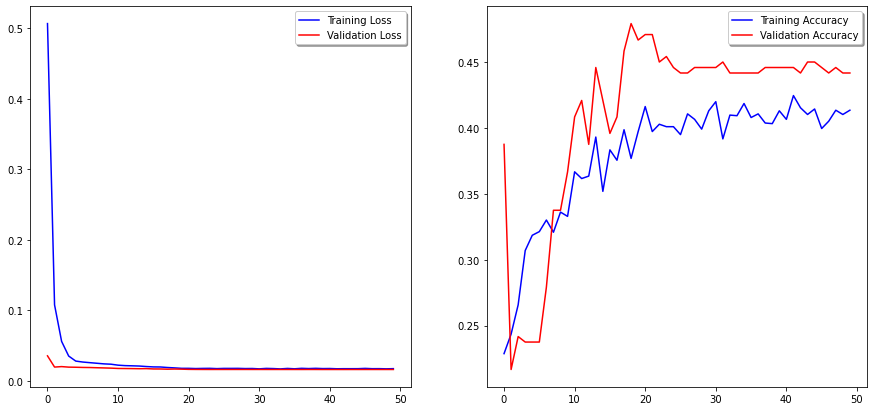

In [18]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'], color='b', label='Training Loss') 
ax1.plot(history.history['val_loss'], color='r', label = 'Validation Loss',axes=ax1)
legend = ax1.legend(loc='best', shadow=True)
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['accuracy'], color='b', label='Training Accuracy') 
ax2.plot(history.history['val_accuracy'], color='r', label = 'Validation Accuracy')
legend = ax2.legend(loc='best', shadow=True)

In [73]:
test_public = test[test.seq_length == 107]
test_private = test[test.seq_length == 130]
test_public_ids = test_public['id'].values
test_private_ids = test_private['id'].values
test_public_img = []
for ID in test_public_ids:
    img_path = os.path.join(bpps_dir,ID+'.npy')
    img = np.load(img_path)
    test_public_img.append(img)

test_private_img = []
for ID in test_private_ids:
    img_path = os.path.join(bpps_dir,ID+'.npy')
    img = np.load(img_path)
    test_private_img.append(img)

In [74]:
test_public_img = np.array(test_public_img).reshape(-1, 107, 107, 1)
test_private_img = np.array(test_private_img).reshape(-1, 130, 130, 1)

In [75]:
pred_public = model.predict(test_public_img)
pred_public = np.repeat(pred_public,repeats=107,axis=0)
pred_private = np.repeat(np.array([0,0,0,0,0]),repeats=130*3005,axis=0).reshape(-1,5)
prediction = np.concatenate((pred_public,pred_private),axis=0)

In [88]:
sub_CNN = pd.DataFrame(prediction)
seqpos = submission.id_seqpos.values
sub_CNN['id_seqpos'] = seqpos

In [85]:
sub_CNN.head()

0         1         2         3         4       id_seqpos
0 -0.007458  0.006744  0.006587 -0.012859  0.031772  id_00073f8be_0
1 -0.007458  0.006744  0.006587 -0.012859  0.031772  id_00073f8be_1
2 -0.007458  0.006744  0.006587 -0.012859  0.031772  id_00073f8be_2
3 -0.007458  0.006744  0.006587 -0.012859  0.031772  id_00073f8be_3
4 -0.007458  0.006744  0.006587 -0.012859  0.031772  id_00073f8be_4

### <span style='color:Green'> GRU </span>

##### Variables et fonctions d'aide pour prétraiter les données d'entrée

In [153]:
# This function would help us converting the target variables into an array which can be fed into keras model
def pandas_list_to_array(df):
    """
    Input: dataframe of shape (x, y), containing list of length l
    Return: np.array of shape (x, l, y)
    """
    
    return np.transpose(
        np.array(df.values.tolist()),
        (0, 2, 1)
    )

In [154]:
# We are defining a function here to take care of the conversion
# df would be the training or the test dataset
# token2int is dictionary which contains the character/integer mapping

def preprocess_inputs(df, token2int, cols=['sequence', 'structure', 'predicted_loop_type']):
    return pandas_list_to_array(
        df[cols].applymap(lambda seq: [token2int[x] for x in seq])
    )

In [155]:
# predictor variables
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']
# we are using a dictinoary here to map each character with a unique integer
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

# calling the function defined above to apply the actual character to integer conversion
# train_inputs is the dataframe we are going to use to feed our keras model
train_inputs = preprocess_inputs(train, token2int)

# call the function to reshape the predictor variables to convert into an array which can be fed into keras model
train_labels = pandas_list_to_array(train[pred_cols])


In [156]:
# sets the random seed
tf.random.set_seed(2020)
np.random.seed(2020)

In [157]:
# This is to generate a new set of random values every time
y_true = tf.random.normal((32, 68, 3))
y_pred = tf.random.normal((32, 68, 3))

##### MCRMSE - Mean Columnwise Root Mean Squared Error

MCRMSE est la métrique d'évaluation utilisée dans ce concours.

La raison pour laquelle nous utilisons MCRMSE dans ces défis est qu'il y a plusieurs extrants que nous essayons de prédire.

Normalement, nous pouvons calculer RMSE pour obtenir une métrique d'évaluation à un seul nombre pour notre prédiction, mais si nous prédisons plusieurs valeurs à la fois - dans le cas de la concurrence OpenVaccine, nous devons prédire les taux de dégradation dans plusieurs conditions - nous obtiendrions plusieurs différentes valeurs RMSE, une pour chaque colonne.

Le MCRMSE est simplement une moyenne de toutes les valeurs RMSE pour chacune de nos colonnes, nous pouvons donc toujours utiliser une métrique d'évaluation à un seul numéro, même dans le cas de sorties multiples.

In [158]:
# function to calculate average across all RMSE values for each column
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

##### GRU LAYER

In [159]:
def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(
        hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))

In [160]:
def build_model(embed_size, seq_len=107, pred_len=68, dropout=0.5, 
                sp_dropout=0.2, embed_dim=200, hidden_dim=256, n_layers=3):
    inputs = L.Input(shape=(seq_len, 3))
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3])
    )
    hidden = L.SpatialDropout1D(sp_dropout)(reshaped)
    
    for x in range(n_layers):
        hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    # Since we are only making predictions on the first part of each sequence, 
    # we have to truncate it
    truncated = hidden[:, :pred_len]
    out = L.Dense(5, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(tf.optimizers.Adam(), loss=MCRMSE)
    
    return model    

In [161]:
x_train, x_val, Y_train, Y_val = train_test_split(
    train_inputs, train_labels, test_size=.1, random_state=34, stratify=train.SN_filter)

In [162]:
public_df = test.query("seq_length == 107")
private_df = test.query("seq_length == 130")

public_inputs = preprocess_inputs(public_df, token2int)
private_inputs = preprocess_inputs(private_df, token2int)

In [163]:
model = build_model(embed_size=len(token2int))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding (Embedding)        (None, 107, 3, 200)       2800      
_________________________________________________________________
tf.reshape (TFOpLambda)      (None, 107, 600)          0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 107, 600)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 107, 512)          1317888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 107, 512)          1182720   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 107, 512)          118272

In [164]:
history = model.fit(
    x_train, Y_train,
    validation_data=(x_val, Y_val),
    batch_size=32,
    epochs=50,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=5),
        tf.keras.callbacks.ModelCheckpoint('model.h5')
    ]
)

Epoch 1/50
68/68 - 289s - loss: 0.5622 - val_loss: 0.5974
Epoch 2/50
68/68 - 282s - loss: 0.5047 - val_loss: 0.5838
Epoch 3/50
68/68 - 285s - loss: 0.4863 - val_loss: 0.5653
Epoch 4/50
68/68 - 282s - loss: 0.4760 - val_loss: 0.5539
Epoch 5/50
68/68 - 283s - loss: 0.4634 - val_loss: 0.5457
Epoch 6/50
68/68 - 302s - loss: 0.4535 - val_loss: 0.5307
Epoch 7/50
68/68 - 277s - loss: 0.4418 - val_loss: 0.5225
Epoch 8/50
68/68 - 282s - loss: 0.4341 - val_loss: 0.5154
Epoch 9/50
68/68 - 280s - loss: 0.4247 - val_loss: 0.5074
Epoch 10/50
68/68 - 281s - loss: 0.4171 - val_loss: 0.5037
Epoch 11/50
68/68 - 282s - loss: 0.4108 - val_loss: 0.5030
Epoch 12/50
68/68 - 279s - loss: 0.4059 - val_loss: 0.4944
Epoch 13/50
68/68 - 281s - loss: 0.4017 - val_loss: 0.4937
Epoch 14/50
68/68 - 281s - loss: 0.3974 - val_loss: 0.4887
Epoch 15/50
68/68 - 280s - loss: 0.3941 - val_loss: 0.4904
Epoch 16/50
68/68 - 282s - loss: 0.3916 - val_loss: 0.4892
Epoch 17/50
68/68 - 281s - loss: 0.3879 - val_loss: 0.4851
Epoch 

##### Nous verrons l'état du modèle

In [165]:
import plotly.express as px
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'MCRMSE'}, 
    title='Training History')
fig.show()

##### Predictions

In [55]:
# although it's not the case for the training data.
model_public = build_model(seq_len=107, pred_len=107, embed_size=len(token2int))
model_private = build_model(seq_len=130, pred_len=130, embed_size=len(token2int))

model_public.load_weights('model.h5')
model_private.load_weights('model.h5')

In [56]:
public_preds = model_public.predict(public_inputs)
private_preds = model_private.predict(private_inputs)

##### Post-processing and submit

Pour chaque échantillon, nous prenons les tenseurs de forme prédits (107, 5) ou (130, 5), et les convertissons au format long (i.e. 629 × 107,5 ou 3005 × 130,5):

In [57]:
preds_ls = []
for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)
preds_df.head()

reactivity  deg_Mg_pH10  deg_Mg_50C  deg_pH10   deg_50C       id_seqpos
0    0.654481     0.655962    0.559426  2.188097  0.821408  id_00073f8be_0
1    2.167268     2.863357    3.045832  4.179893  2.787225  id_00073f8be_1
2    1.487265     0.602232    0.764195  0.704503  0.742116  id_00073f8be_2
3    1.285672     1.117906    1.734100  1.179140  1.836536  id_00073f8be_3
4    0.850499     0.517648    0.848276  0.548125  0.866028  id_00073f8be_4

In [58]:
submission_gru = submission[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
submission_gru.to_csv('submission_gru.csv', index=False)

### <span style='color:Green'> LinearRegression </span>

In [105]:
FOLDS = 5
SEED = 43
train2 = train.sample(frac=1, random_state=SEED).reset_index(drop=True)
train2['kfold'] = -1
kf = KFold(n_splits = FOLDS, random_state=SEED, shuffle=True)
for f, (t_, v_) in enumerate(kf.split(X=train2)):
    train2.loc[v_, 'kfold'] = f

In [106]:
train2.kfold.value_counts()

3    480
1    480
4    480
2    480
0    480
Name: kfold, dtype: int64

In [107]:
def mcrmse_loss(y_true, y_pred, N=3):
    assert len(y_true) == len(y_pred)
    n = len(y_true)
    return np.sum(np.sqrt(np.sum((y_true - y_pred)**2, axis=0)/n)) / N

In [108]:
features = ['sequence', 'structure', 'predicted_loop_type']
targets = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']
preds_list = []

def run(fold):
    
    # training and validation sets
    Xlin_train = train2[train2.kfold != fold].reset_index(drop=True)
    Xlin_valid = train2[train2.kfold == fold].reset_index(drop=True)
    
    # training and validation labels
    ylin_train = Xlin_train[targets]
    ylin_valid = Xlin_valid[targets]
    
    # encode features
    # initialize OneHotEncoder from sklearn
    # we use handle_unknown='ignore' just because it is a baseline
    # but we should figure it out a better way to encode the unknown values
    # that we are going to find in the test dataset
    ohe = preprocessing.OneHotEncoder(handle_unknown='ignore')
    
    # fit ohe on training and validation features
    full_data = pd.concat(
        [Xlin_train[features], Xlin_valid[features]],
        axis=0
    )
    ohe.fit(full_data[features])
    
    # transform training and validation data
    Xlin_train = ohe.transform(Xlin_train[features])
    Xlin_valid = ohe.transform(Xlin_valid[features])
    xlin_test = ohe.transform(test[features])
    
    # initialize regression model
    model = linear_model.LinearRegression()
    
    # fit the model on training data
    model.fit(Xlin_train, ylin_train)
    
    # predict on validation data
    valid_preds = model.predict(Xlin_valid)
    
    mcrmse = mcrmse_loss(ylin_valid, valid_preds)
    print(f"FOLD {fold}")
    print(f"Valid MCRMSE: {mcrmse}")
    print("")
    
    # predict on test dataset
    preds = model.predict(xlin_test)
    preds_list.append(preds)

In [109]:
for f in range(FOLDS):
    run(f)

FOLD 0
Valid MCRMSE: 0.12362867291194533

FOLD 1
Valid MCRMSE: 0.1074751617265305

FOLD 2
Valid MCRMSE: 0.11309320423512019

FOLD 3
Valid MCRMSE: 0.10654421441338106

FOLD 4
Valid MCRMSE: 0.11778363321925349



##### Prédictions et Validation

In [110]:
# average predictions of each of the folds models
predictions = (preds_list[0] + preds_list[1] + preds_list[2] +
               preds_list[3] + preds_list[4]) / FOLDS

predictions = pd.DataFrame(predictions)

In [111]:
# Create submission csv
submission_df = predictions.loc[predictions.index.repeat(list(test['seq_length']))].reset_index(drop=True)
submission_df = submission_df.rename(columns={0: 'reactivity', 1: 'deg_Mg_pH10', 2: 'deg_Mg_50C'})
submission_df['id_seqpos'] = submission['id_seqpos']
submission_df['deg_pH10'] = 0.0
submission_df['deg_50C'] = 0.0
submission_df = submission_df[['id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
submission_df.head()

id_seqpos  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C  deg_50C
0  id_00073f8be_0    0.422273     0.494415       0.0    0.486232      0.0
1  id_00073f8be_1    0.422273     0.494415       0.0    0.486232      0.0
2  id_00073f8be_2    0.422273     0.494415       0.0    0.486232      0.0
3  id_00073f8be_3    0.422273     0.494415       0.0    0.486232      0.0
4  id_00073f8be_4    0.422273     0.494415       0.0    0.486232      0.0

### <span style='color:Green'> TSNE </span>

In [41]:
public_df = test.query("seq_length == 107")
private_df = test.query("seq_length == 130")

pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [42]:
train_dict = {}
for col in ['sequence','structure','predicted_loop_type']:
        for sentence in train[col].iteritems():
            char_list = list(sentence[1])
            for i,c in enumerate(char_list):
                if f"{col}_{str(i)}" in train_dict:
                    train_dict[f"{col}_{str(i)}"].append(c)
                else:
                    train_dict[f"{col}_{str(i)}"] = [c]
                    
# public_df   
public_dict = {}
for col in ['sequence','structure','predicted_loop_type']:
        for sentence in public_df[col].iteritems():
            char_list = list(sentence[1])
            for i,c in enumerate(char_list):
                if f"{col}_{str(i)}" in public_dict:
                    public_dict[f"{col}_{str(i)}"].append(c)
                else:
                    public_dict[f"{col}_{str(i)}"] = [c]
                    
# private_df  
private_dict = {}
for col in ['sequence','structure','predicted_loop_type']:
        for sentence in private_df[col].iteritems():
            char_list = list(sentence[1])
            for i,c in enumerate(char_list):
                if f"{col}_{str(i)}" in private_dict:
                    private_dict[f"{col}_{str(i)}"].append(c)
                else:
                    private_dict[f"{col}_{str(i)}"] = [c]

In [43]:
train_df = pd.DataFrame(train_dict)

In [44]:
train_df_one_hot = pd.get_dummies(train_df)
for col,chars in zip(['sequence','structure','predicted_loop_type'],[['G','A', 'C', 'U'],['.', '(', ')'],['E', 'S', 'H', 'B', 'X','I','M']]):
    print(col,chars)
    for i in range(107):
        for char in chars:
            if f"{col}_{i}_{char}" not in train_df_one_hot.columns:
                train_df_one_hot[f"{col}_{i}_{char}"] = 0

sequence ['G', 'A', 'C', 'U']
structure ['.', '(', ')']
predicted_loop_type ['E', 'S', 'H', 'B', 'X', 'I', 'M']


In [45]:
select_features = []
public_df = pd.DataFrame(public_dict)
public_df_one_hot = pd.get_dummies(public_df)
for col,chars in zip(['sequence','structure','predicted_loop_type'],[['G','A', 'C', 'U'],['.', '(', ')'],['E', 'S', 'H', 'B', 'X','I','M']]):
    for i in range(107):
        for char in chars:
            select_features.append(f"{col}_{i}_{char}")
            if f"{col}_{i}_{char}" not in public_df_one_hot.columns:
                public_df_one_hot[f"{col}_{i}_{char}"] = 0

In [46]:
private_df = pd.DataFrame(private_dict)
private_df_one_hot = pd.get_dummies(private_df)
for col,chars in zip(['sequence','structure','predicted_loop_type'],[['G','A', 'C', 'U'],['.', '(', ')'],['E', 'S', 'H', 'B', 'X','I','M']]):
    for i in range(130):
        for char in chars:
            if f"{col}_{i}_{char}" not in private_df_one_hot.columns:
                private_df_one_hot[f"{col}_{i}_{char}"] = 0

In [47]:
print("Train Features Shape : ",train_df_one_hot.shape)
print("Public Features Shape : ",public_df_one_hot.shape)
print("private Features Shape : ",private_df_one_hot.shape)

Train Features Shape :  (2400, 1498)
Public Features Shape :  (629, 1498)
private Features Shape :  (3005, 1820)


##### Méthode pour diminuer la dimension en TSNE 2D

In [48]:
def get_tsne(X):
    X_reshape = X.reshape(len(X),-1)
    tsne = TSNE(n_components=2 ,init='pca', n_iter=2500, random_state=23)
    X_reshape_2D = tsne.fit_transform(X_reshape)
    return X_reshape_2D

##### Plot TSNE

Individual data

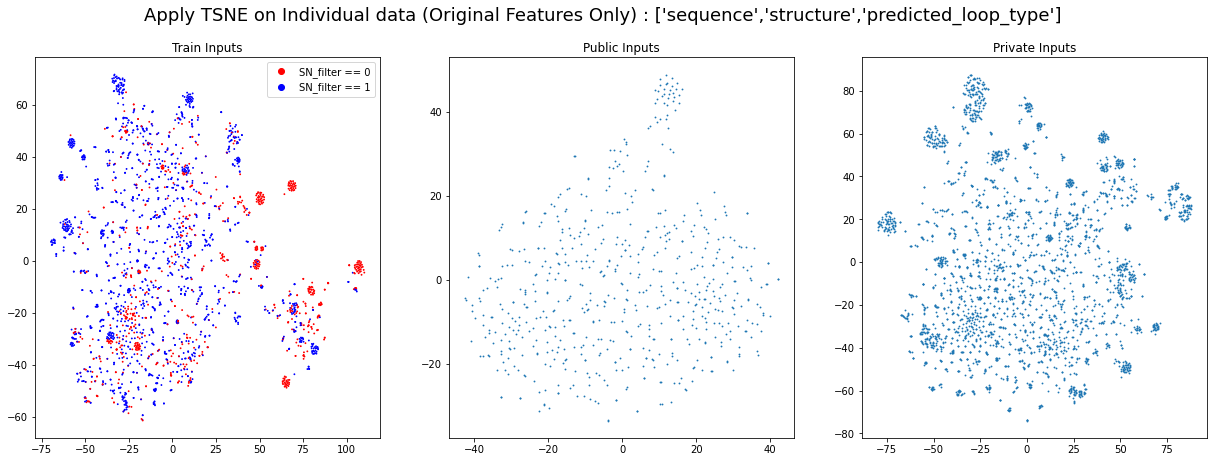

In [50]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,7))
fig.suptitle("Apply TSNE on Individual data (Original Features Only) : ['sequence','structure','predicted_loop_type']", fontsize=18)

train_2D = get_tsne(train_df_one_hot[select_features].values)
train_SN_filter = train_SN_filter = train['SN_filter'].values
classes = ['SN_filter == 0', 'SN_filter == 1']
colours = ListedColormap(['r','b'])
ax1.set(title="Train Inputs")
scatter = ax1.scatter(train_2D[:,0], train_2D[:,1],c=train_SN_filter,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

public_2D = get_tsne(public_df_one_hot[select_features].values)
scatter = ax2.scatter(public_2D[:,0], public_2D[:,1],s = 0.7)
ax2.set(title="Public Inputs")

private_2D = get_tsne(private_df_one_hot.values)
scatter = ax3.scatter(private_2D[:,0], private_2D[:,1],s = 0.7)
ax3.set(title="Private Inputs")

plt.savefig('0.png')
plt.show()

###### Train + Public

Train Features Shape :  (2400, 1498)
Public Features Shape :  (629, 1498)
test_public Shape:  (3029, 1498)


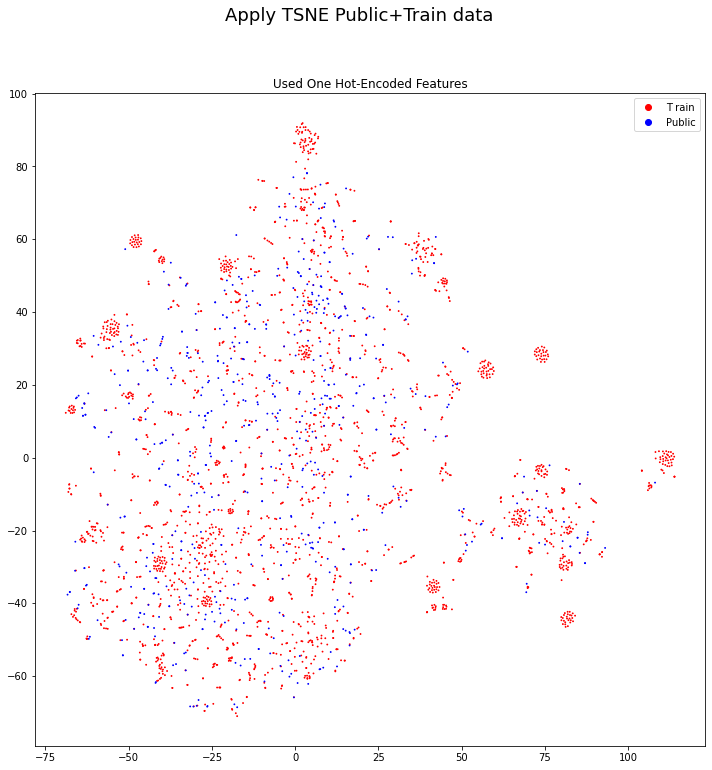

In [49]:
test_public = np.vstack([train_df_one_hot[select_features].values, public_df_one_hot[select_features].values])
print("Train Features Shape : ",train_df_one_hot.shape)
print("Public Features Shape : ",public_df_one_hot.shape)
print("test_public Shape: ",test_public.shape)

test_public_2D = get_tsne(test_public)
test_public_y = [0]*len(train_df_one_hot) + [1]*len(public_df_one_hot) 
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
fig.suptitle("Apply TSNE Public+Train data", fontsize=18)
classes = ['T rain', 'Public']
colours = ListedColormap(['r','b'])
ax1.set(title="Used One Hot-Encoded Features")
scatter = ax1.scatter(test_public_2D[:,0], test_public_2D[:,1],c=test_public_y,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.savefig('1.png')
plt.show()

Train Features Shape :  (2400, 1498)
Public Features Shape :  (629, 1498)
private Features Shape :  (3005, 1820)
X_all Shape:  (6034, 1498)


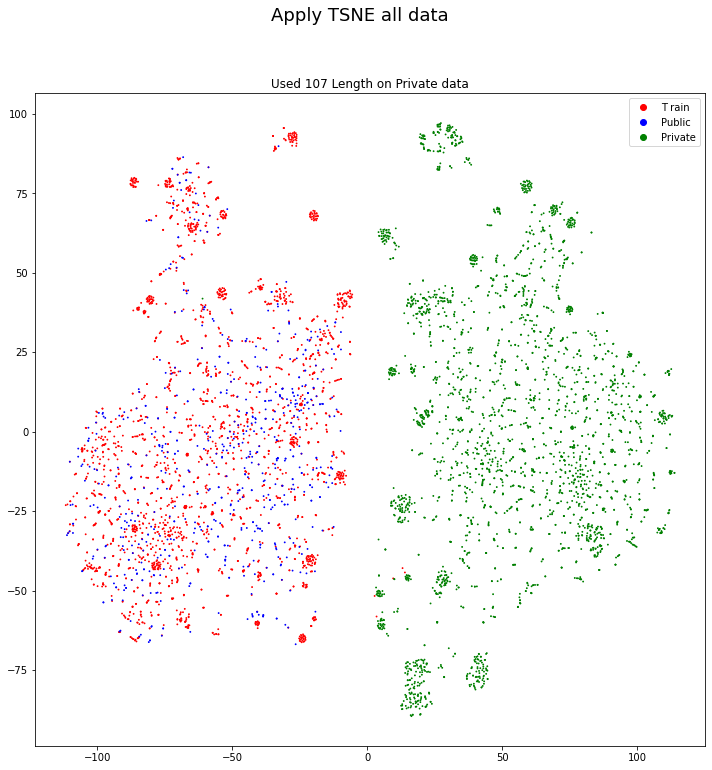

In [51]:
X_all = np.vstack([train_df_one_hot[select_features].values, public_df_one_hot[select_features].values,private_df_one_hot[select_features].values])
print("Train Features Shape : ",train_df_one_hot.shape)
print("Public Features Shape : ",public_df_one_hot.shape)
print("private Features Shape : ",private_df_one_hot.shape)
print("X_all Shape: ",X_all.shape)

X_all_2D = get_tsne(X_all)
X_all_y = [0]*len(train_df_one_hot) + [1]*len(public_df_one_hot) + [2]*len(private_df_one_hot)
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
fig.suptitle("Apply TSNE all data", fontsize=18)
classes = ['T rain', 'Public', 'Private']
colours = ListedColormap(['r','b','g'])
ax1.set(title="Used 107 Length on Private data")
scatter = ax1.scatter(X_all_2D[:,0], X_all_2D[:,1],c=X_all_y,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.savefig('2.png')
plt.show()

###### BPPS Data

In [52]:
public_df = test.query("seq_length == 107")
private_df = test.query("seq_length == 130")

def read_bpps_max(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"D:/telechargement/stanford-covid-vaccine/bpps/{mol_id}.npy").max(axis=1))
    return bpps_arr

def read_bpps_sum(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps_arr.append(np.load(f"D:/telechargement/stanford-covid-vaccine/bpps/{mol_id}.npy").sum(axis=1))
    return bpps_arr

def read_bpps_nb(df):
    bpps_arr = []
    for mol_id in df.id.to_list():
        bpps = np.load(f"D:/telechargement/stanford-covid-vaccine/bpps/{mol_id}.npy")
        bpps_nb = (bpps > 0).sum(axis=0) / bpps.shape[0]
        bpps_arr.append(bpps_nb)
    return bpps_arr 

train['bpps_max'] = read_bpps_max(train)
public_df['bpps_max'] = read_bpps_max(public_df)
private_df['bpps_max'] = read_bpps_max(private_df)

train['bpps_sum'] = read_bpps_sum(train)
public_df['bpps_sum'] = read_bpps_sum(public_df)
private_df['bpps_sum'] = read_bpps_sum(private_df)

train['bpps_nb'] = read_bpps_nb(train)
public_df['bpps_nb'] = read_bpps_nb(public_df)
private_df['bpps_nb'] = read_bpps_nb(private_df)

train_bpps = np.transpose( np.array(train[['bpps_max','bpps_sum','bpps_nb']].values.tolist()),(0, 2, 1))
public_bpps = np.transpose( np.array(public_df[['bpps_max','bpps_sum','bpps_nb']].values.tolist()),(0, 2, 1))
private_bpps = np.transpose( np.array(private_df[['bpps_max','bpps_sum','bpps_nb']].values.tolist()),(0, 2, 1))

print("train_bpps Shape : ",train_bpps.shape)
print("public_bpps Shape : ",public_bpps.shape)
print("private_bpps Shape : ",private_bpps.shape)

train_bpps Shape :  (2400, 107, 3)
public_bpps Shape :  (629, 107, 3)
private_bpps Shape :  (3005, 130, 3)


train_public_private_bpps_max Shape :  (6034, 107)
train_public_private_bpps_sum Shape :  (6034, 107)
train_public_private_bpps_nb Shape :  (6034, 107)


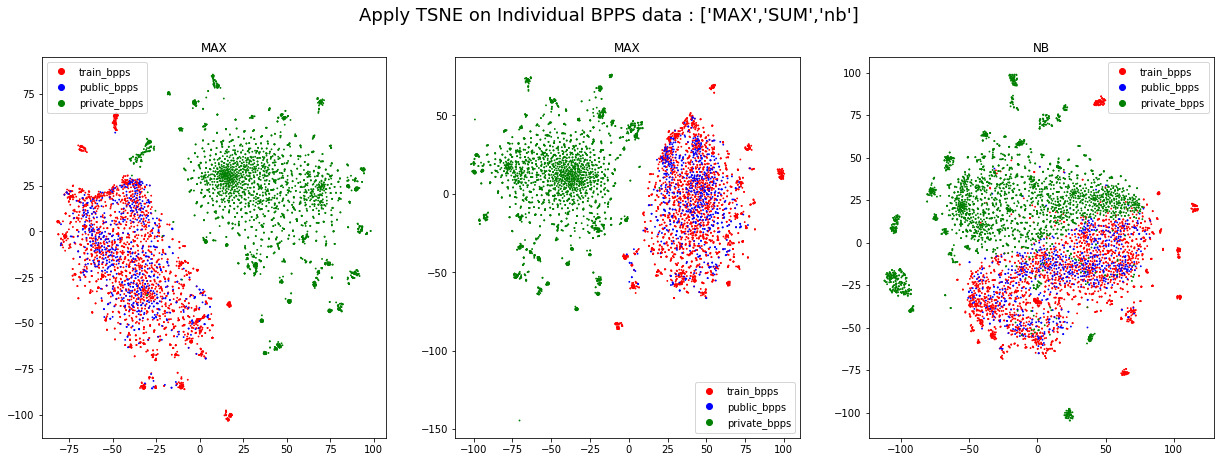

In [53]:
### BPPS Feaures TSNE on individual columns

train_public_private_bpps_max = np.vstack([train_bpps[:,:,0], public_bpps[:,:,0],private_bpps[:,:107,0]])
train_public_private_bpps_sum = np.vstack([train_bpps[:,:,1], public_bpps[:,:,1],private_bpps[:,:107,1]])
train_public_private_bpps_nb = np.vstack([train_bpps[:,:,2], public_bpps[:,:,2],private_bpps[:,:107,2]])

print("train_public_private_bpps_max Shape : ",train_public_private_bpps_max.shape)
print("train_public_private_bpps_sum Shape : ",train_public_private_bpps_sum.shape)
print("train_public_private_bpps_nb Shape : ",train_public_private_bpps_nb.shape)

yy = [0]*len(train_bpps) + [1]*len(public_bpps) + [2]*len(private_bpps)

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,7))
fig.suptitle("Apply TSNE on Individual BPPS data : ['MAX','SUM','nb']", fontsize=18)

train_public_private_bpps_max_2D = get_tsne(train_public_private_bpps_max)
classes = ['train_bpps','public_bpps','private_bpps']
colours = ListedColormap(['r','b','g'])
ax1.set(title="MAX")
scatter = ax1.scatter(train_public_private_bpps_max_2D[:,0], train_public_private_bpps_max_2D[:,1],c=yy,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

train_public_private_bpps_sum_2D = get_tsne(train_public_private_bpps_sum)
classes = ['train_bpps','public_bpps','private_bpps']
colours = ListedColormap(['r','b','g'])
ax2.set(title="MAX")
scatter = ax2.scatter(train_public_private_bpps_sum_2D[:,0], train_public_private_bpps_sum_2D[:,1],c=yy,cmap=colours,s = 0.7)
ax2.legend(handles=scatter.legend_elements()[0], labels=classes)

train_public_private_bpps_nb_2D = get_tsne(train_public_private_bpps_nb)
classes = ['train_bpps','public_bpps','private_bpps']
colours = ListedColormap(['r','b','g'])
ax3.set(title="NB")
scatter = ax3.scatter(train_public_private_bpps_nb_2D[:,0], train_public_private_bpps_nb_2D[:,1],c=yy,cmap=colours,s = 0.7)
ax3.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.savefig('3.png')
plt.show()

train_public_private_input shape :  (6034, 107, 3)


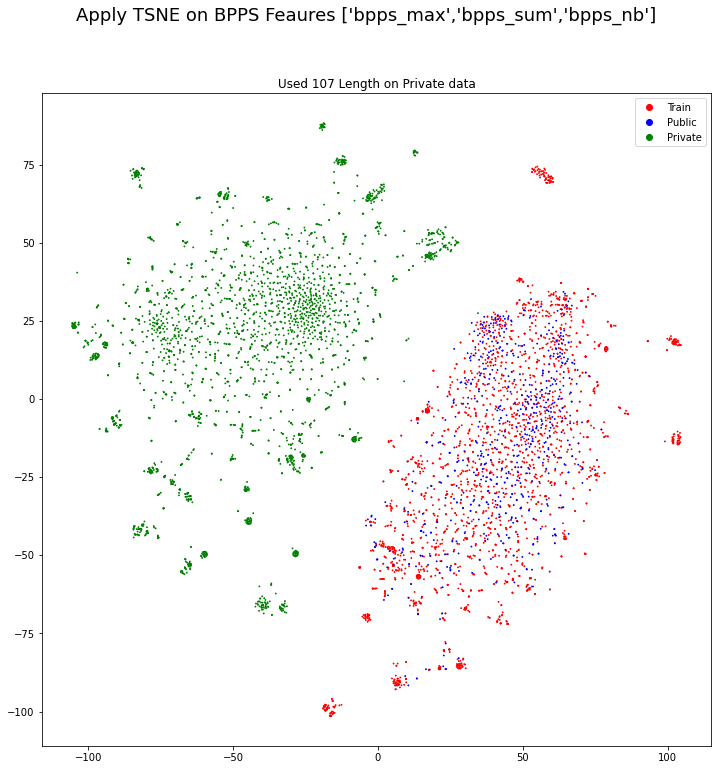

In [54]:
### BPPS Feaures TSNE

train_public_private_bpps = np.vstack([train_bpps, public_bpps,private_bpps[:,:107,:]])
train_public_private_bpps_2D = get_tsne(train_public_private_bpps)
train_public_private_bpps_y = [0]*len(train_bpps)+[1]*len(public_bpps)+[2]*len(private_bpps)

print("train_public_private_input shape : ",train_public_private_bpps.shape)

fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
fig.suptitle("Apply TSNE on BPPS Feaures ['bpps_max','bpps_sum','bpps_nb']", fontsize=18)
classes = ['Train', 'Public', 'Private']
colours = ListedColormap(['r','b','g'])
ax1.set(title="Used 107 Length on Private data")
scatter = ax1.scatter(train_public_private_bpps_2D[:,0], train_public_private_bpps_2D[:,1],c=train_public_private_bpps_y,cmap=colours,s = 0.7)
ax1.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.savefig('4.png')
plt.show()